# Measurements Reindexing Mainnet

These measurements were made on a full node on GCP (Google Compute) reindexing mainnet.

The host is type `n1-standard-1` which means:
 * 1 virtual CPU (pinned to the host CPU)
 * 4096 MB of RAM, of which about 3.6 GB is available to userspace
 * Very slow disks (connected to some kind of SAN)
 
Bitcoin itself is configured with `dbcache=2048`.

## Motivation

The motivation here is to make IBD work better on machines with slow disks. For instance, on most cloud instances IBD will be extremely I/O bound, to the point that it's basically impossible to actually finish syncing a node. This is true even on hosts that have a relatively large amount of memory, and therefore ought to be able ot keep most of the dataset in memory.

## A Priori Memory Predictions

How much memory would we expect the UTXO set to use if it was fully loaded into memory? We can calculate this with the size of keys/values and the number of entries in the UTXO set.

Even on hosts that don't have this much memory for their dbcache, hosts that have a reasonable proportion of that memory (e.g. 50% of it) ought to see a big speedup.

In [41]:
coutpoint_size = 36  # sizeof(COutPoint)
cache_entry_size = 56  # sizeof(CCoinsCacheEntry)
current_utxo_size = 57.3e6  # approximate number of entries in the current uxto set
estimated_map_size = (coutpoint_size + cache_entry_size) * current_utxo_size
print('Estimated memory: {:1.2f} GB'.format(estimated_map_size / (1<<30)))

Estimated memory: 4.91 GB


Note that this estimate assumes no overhead for the space taken by the hash table itself. Therefore we should consider it a lower bound on the amount of memory that would be needed. Given a properly tuned hash table though the real world results shouldn't take that much more memory.

## Measurements

In [56]:
%matplotlib inline

import os
import pickle

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

matplotlib.rcParams['figure.dpi']= 300
matplotlib.rcParams['figure.figsize'] = [12, 8]

def plot(df, title=None, show_flush=True, secondary_y=[], ylabel='', ylabel2=''):
    """Generate a plot from a datafame, with flushes overlaid."""
    plt.figure()
    ax = df.plot(title=title, secondary_y=secondary_y)
    if ylabel:
        ax.set_ylabel(ylabel)
    if ylabel2:
        ax.right_ax.set_ylabel(ylabel2)
    if show_flush:
        for t in flushes.index:
            plt.axvline(x=t, color='k', linestyle=':')

In [90]:
# this loads the local file unpack.py, force reloading it if necessary
import importlib
import sys
try:
    unpack = sys.modules['unpack']
    importlib.reload(unpack)
except KeyError:
    import unpack

# load the data and print some information about it
data = unpack.unpack_data()
frames = data['frames']

print()
print('Host Info')
print('---------')
for k, v in data['hostinfo'].items():
    print('{:16s}{}'.format(k, v))

print()
print('Data Frames')
print('-----------')
print(' '.join(sorted(frames.keys())))

# naughty
globals().update(frames)

Loading data from input file /home/evan/logs/core-leveldb-1518996042.log

Host Info
---------
date            2018-02-18T23:20:42+00:00
hostname        core-leveldb
uname           4.14.18-300.fc27.x86_64
memtotal        3871969280
fdlimit         4096
git:commit      89861173caff8c19700c7a844a8c70750345917a
git:branch      leveldb_tweaks

Data Frames
-----------
bio cache flushes leveldb memory updatetip vfs


In [66]:
# List of all flush events that happened
flushes

,coins:bytes,coins:count
2018-02-18 18:33:31.297333,568537424,3938697
2018-02-18 18:39:35.098202,568912432,3942292
2018-02-18 18:46:41.850309,568525040,3966545
2018-02-18 18:51:28.357541,568454416,3967196


### Indexing Rate (Height)

In this section we'll look at how fast the chain is syncing, measured by the chain height.

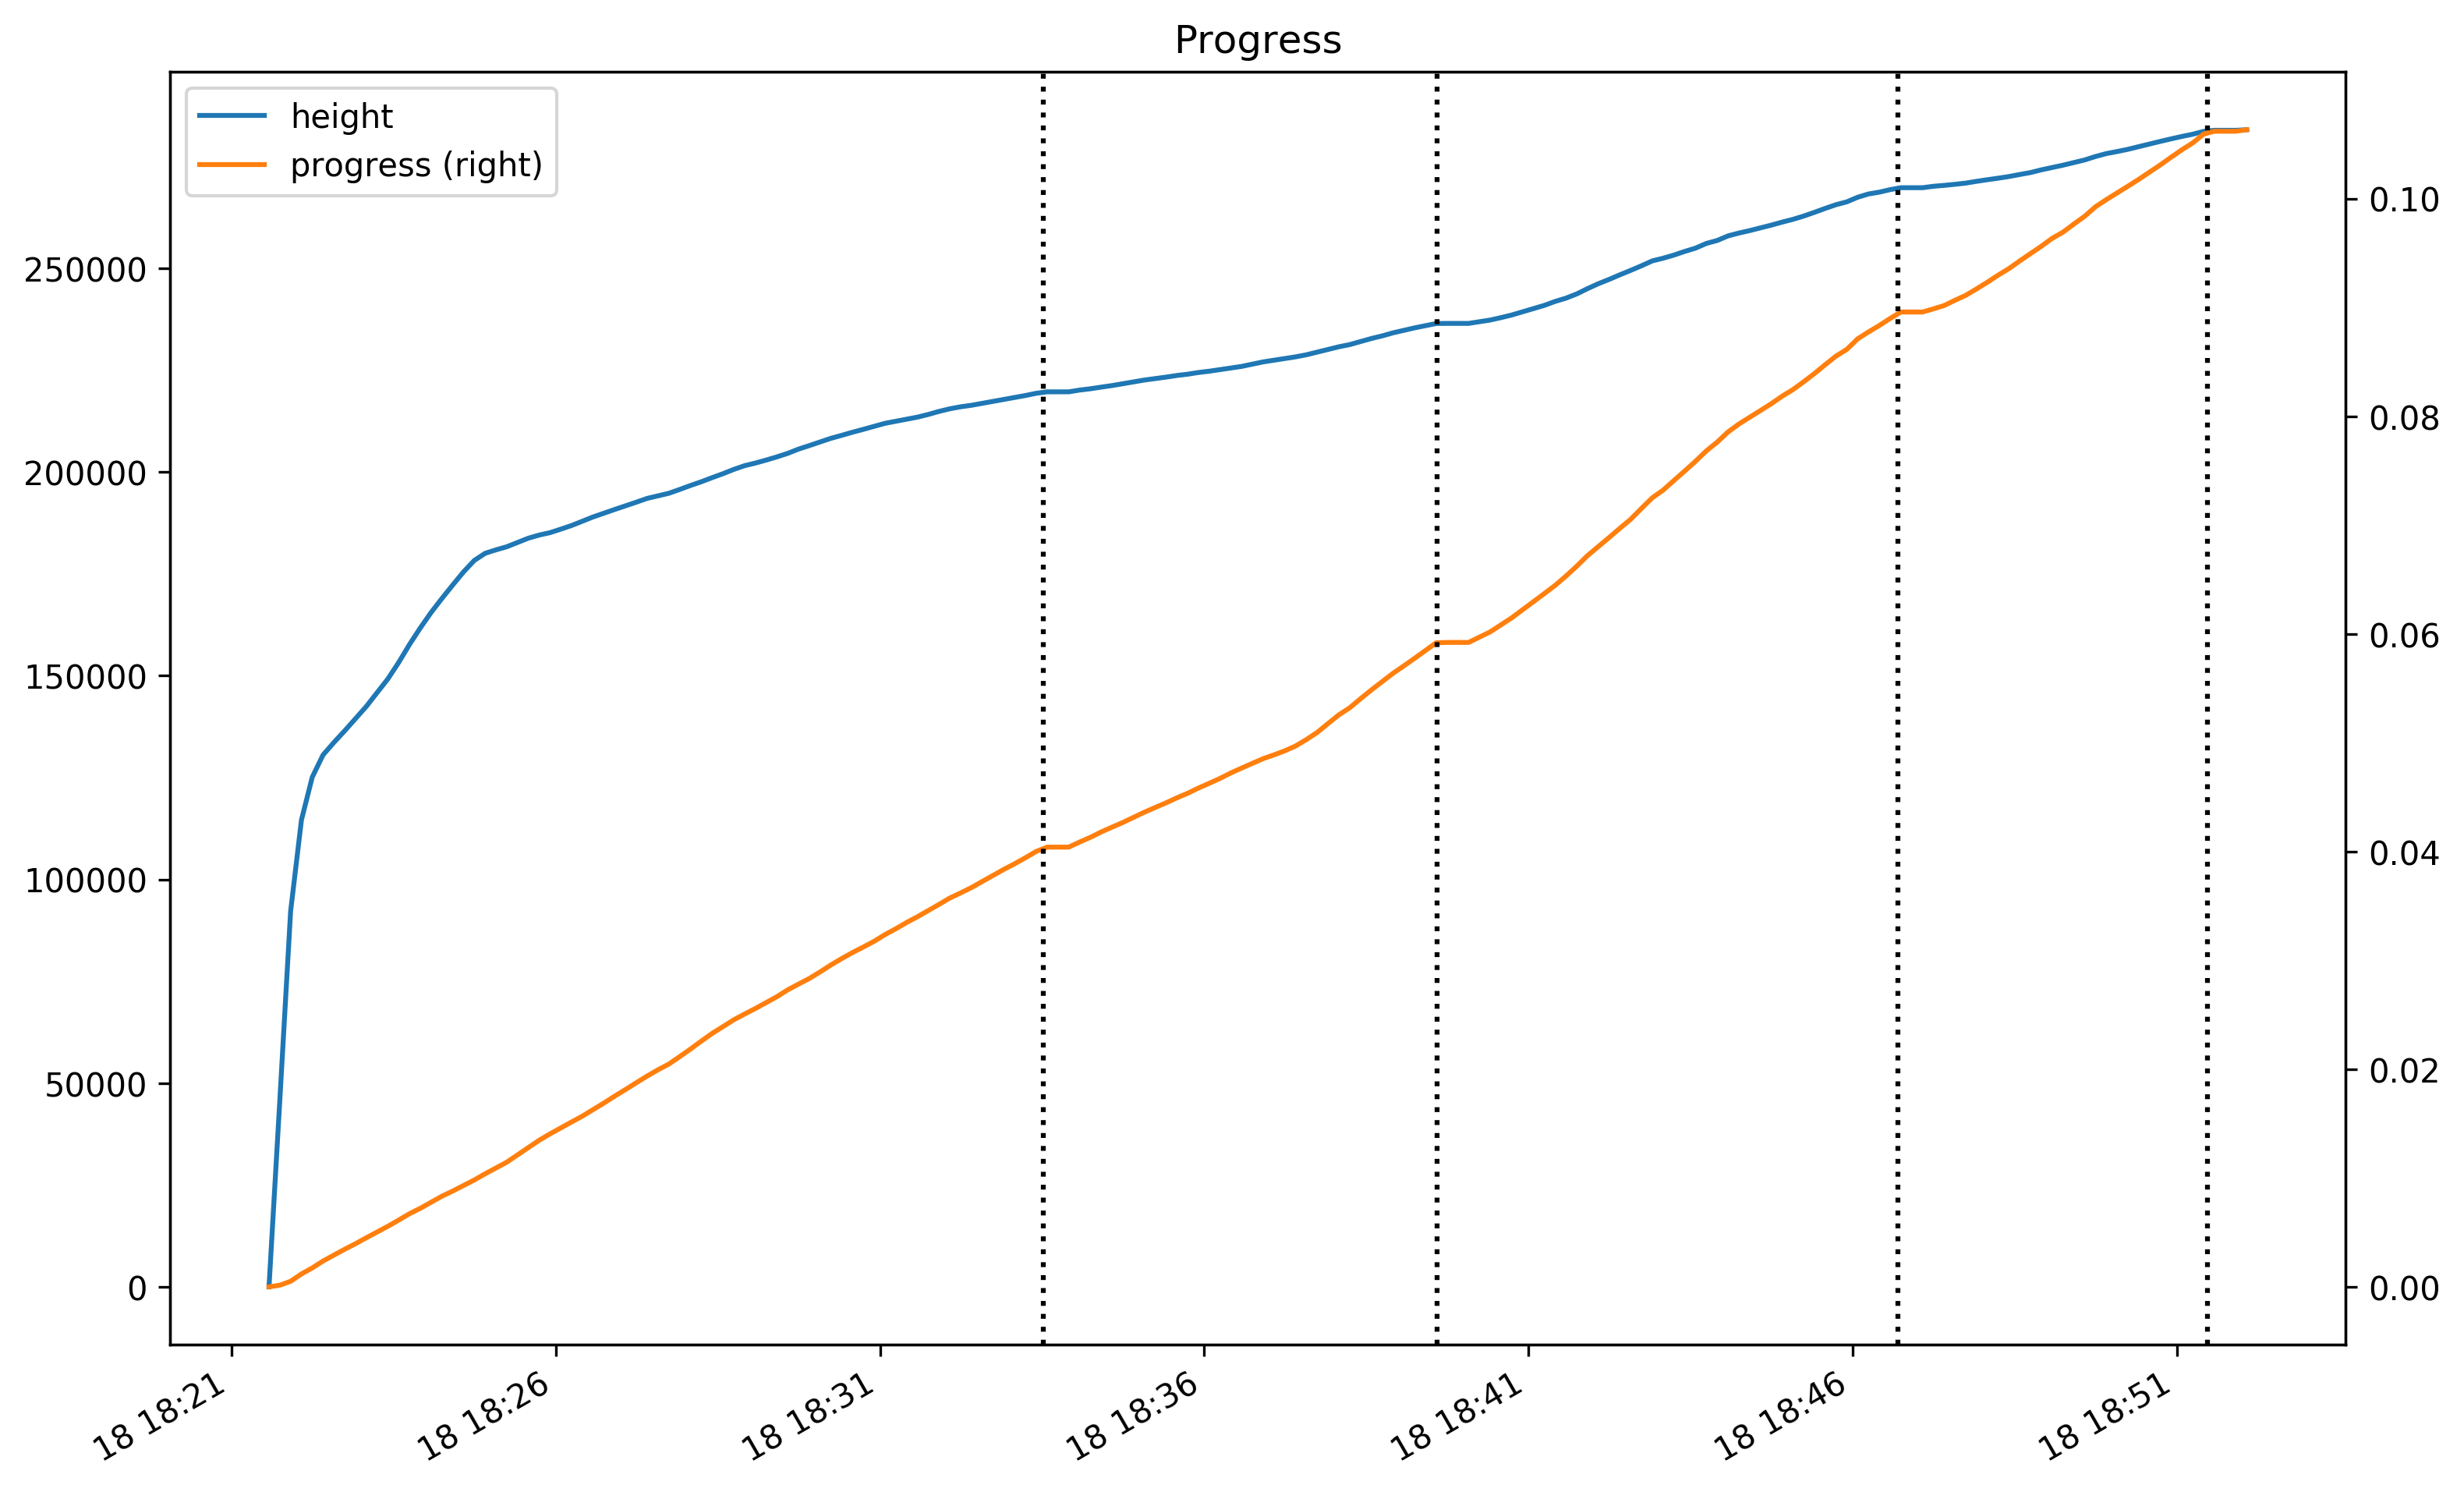

In [67]:
df = updatetip[['height', 'progress']]
plot(progress, title='Progress', secondary_y=['progress'])

### Cache Hits

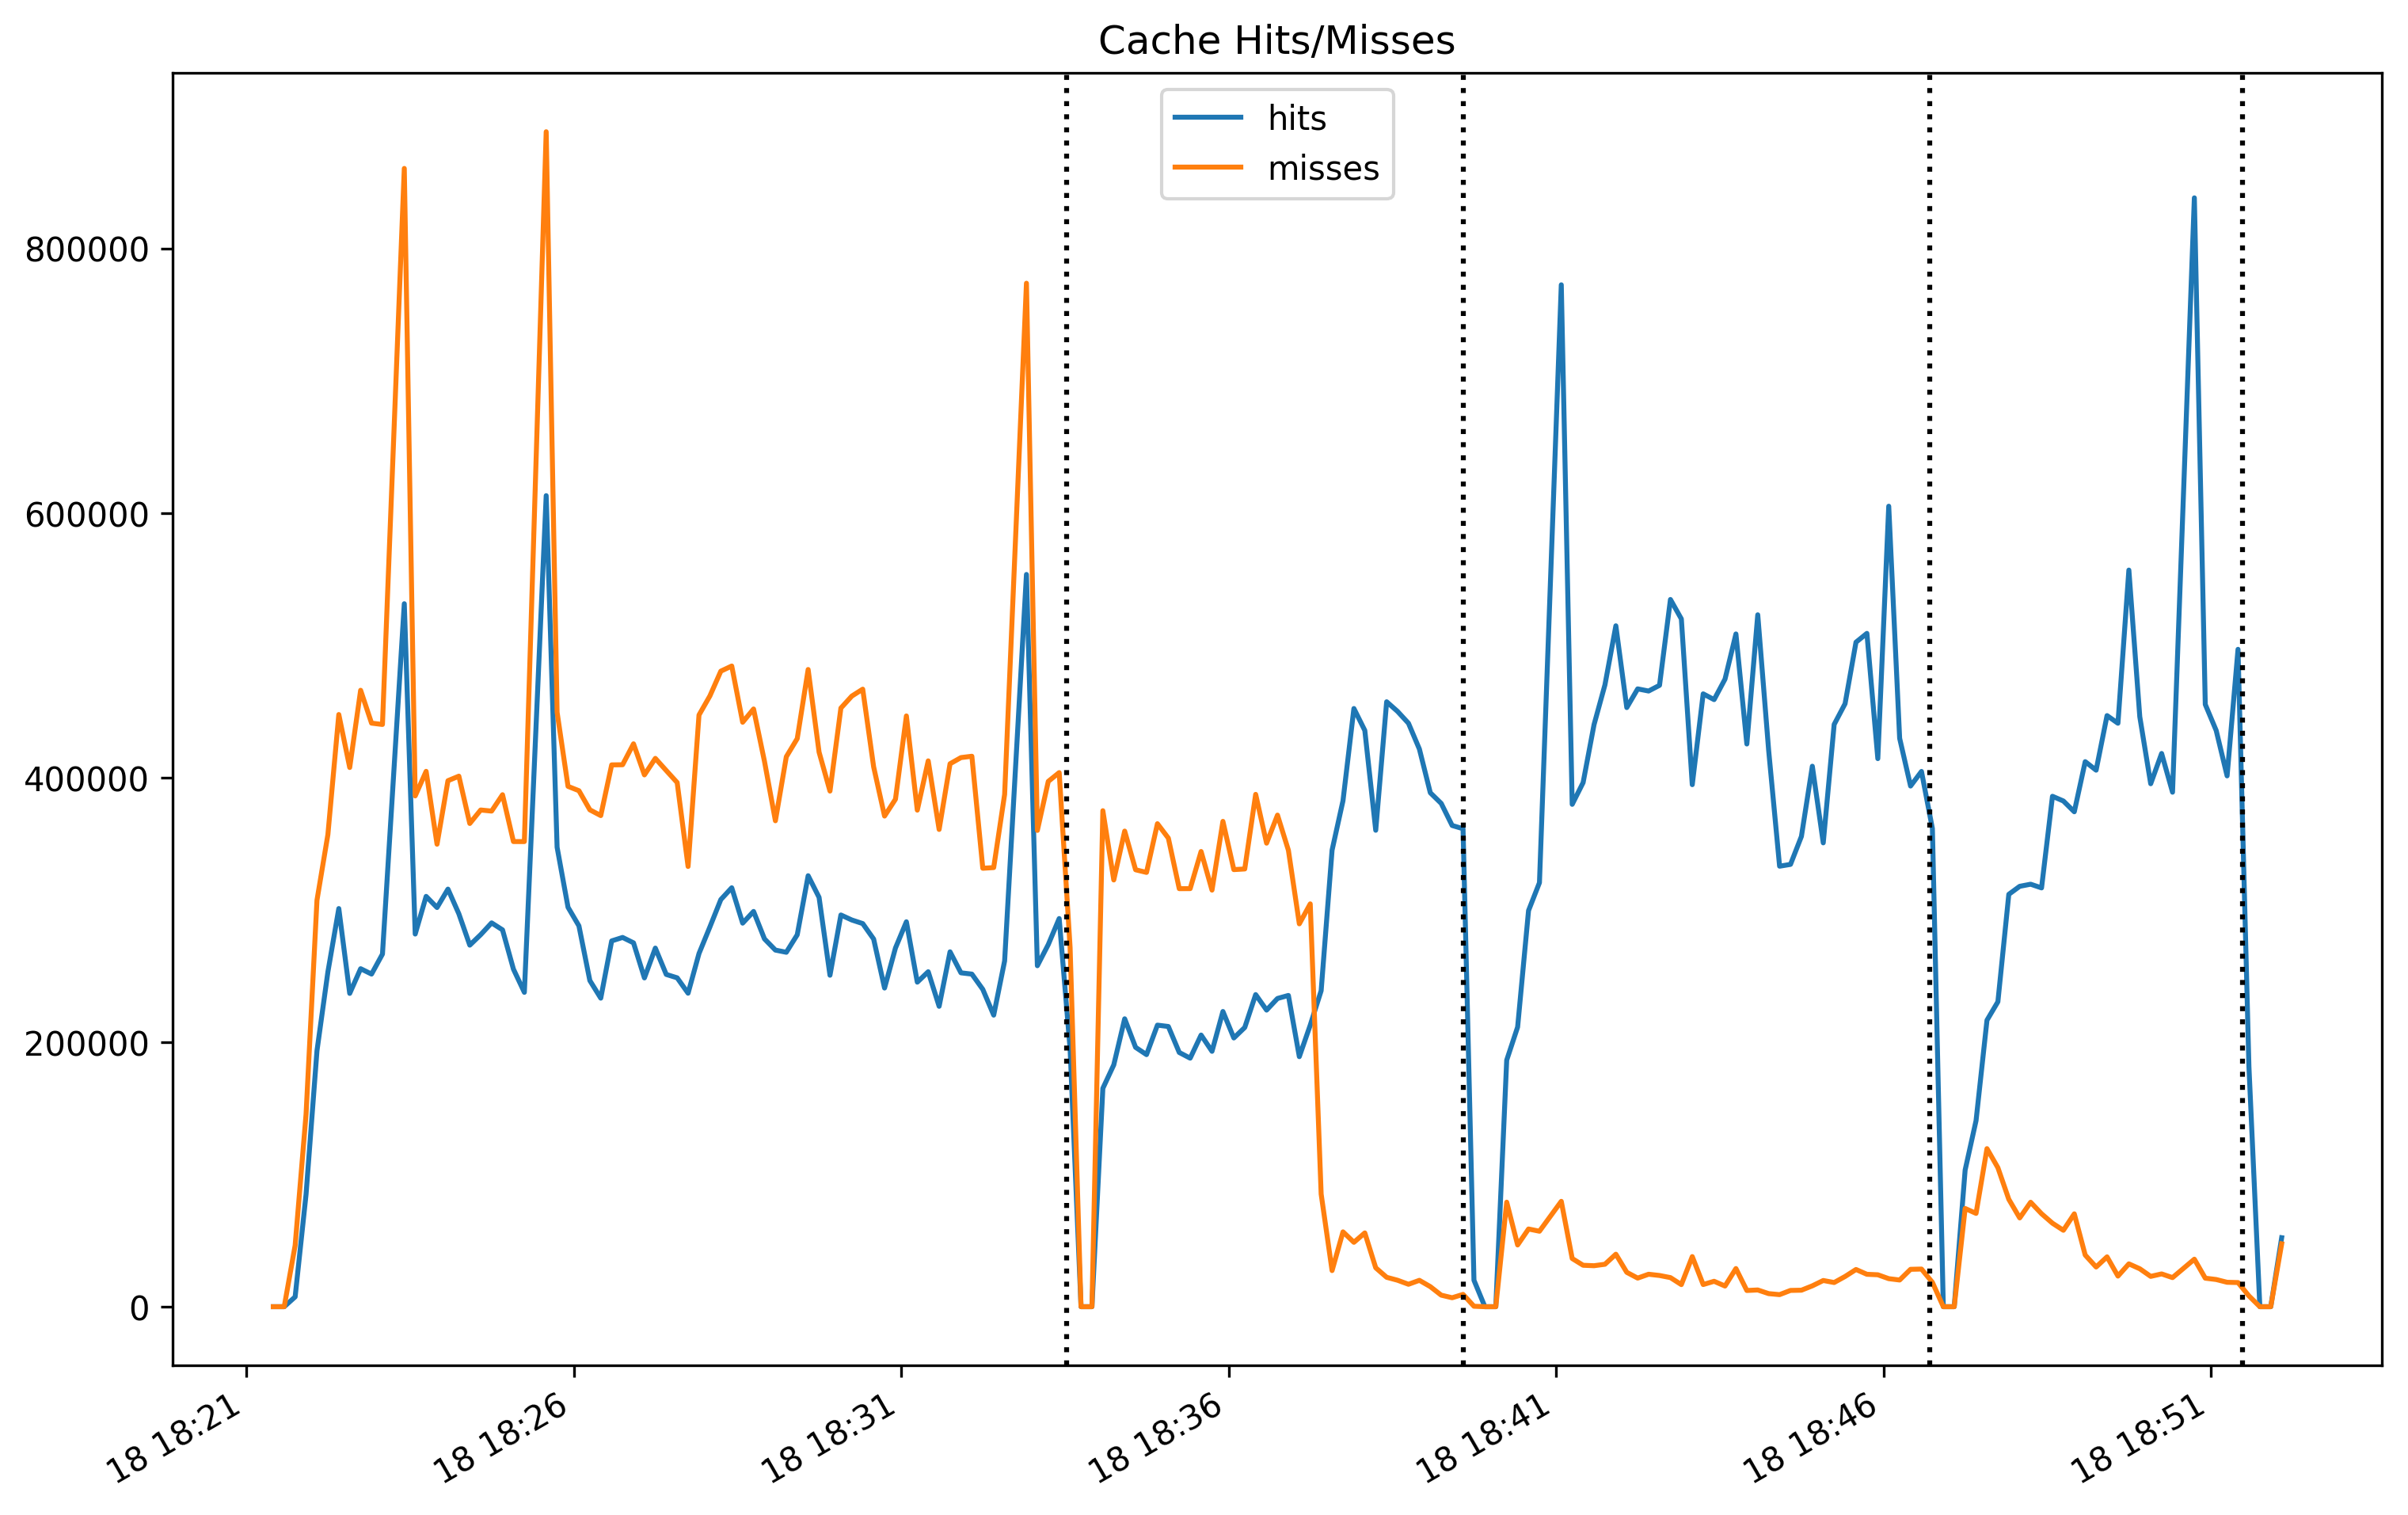

In [68]:
plot(cache, title='Cache Hits/Misses')

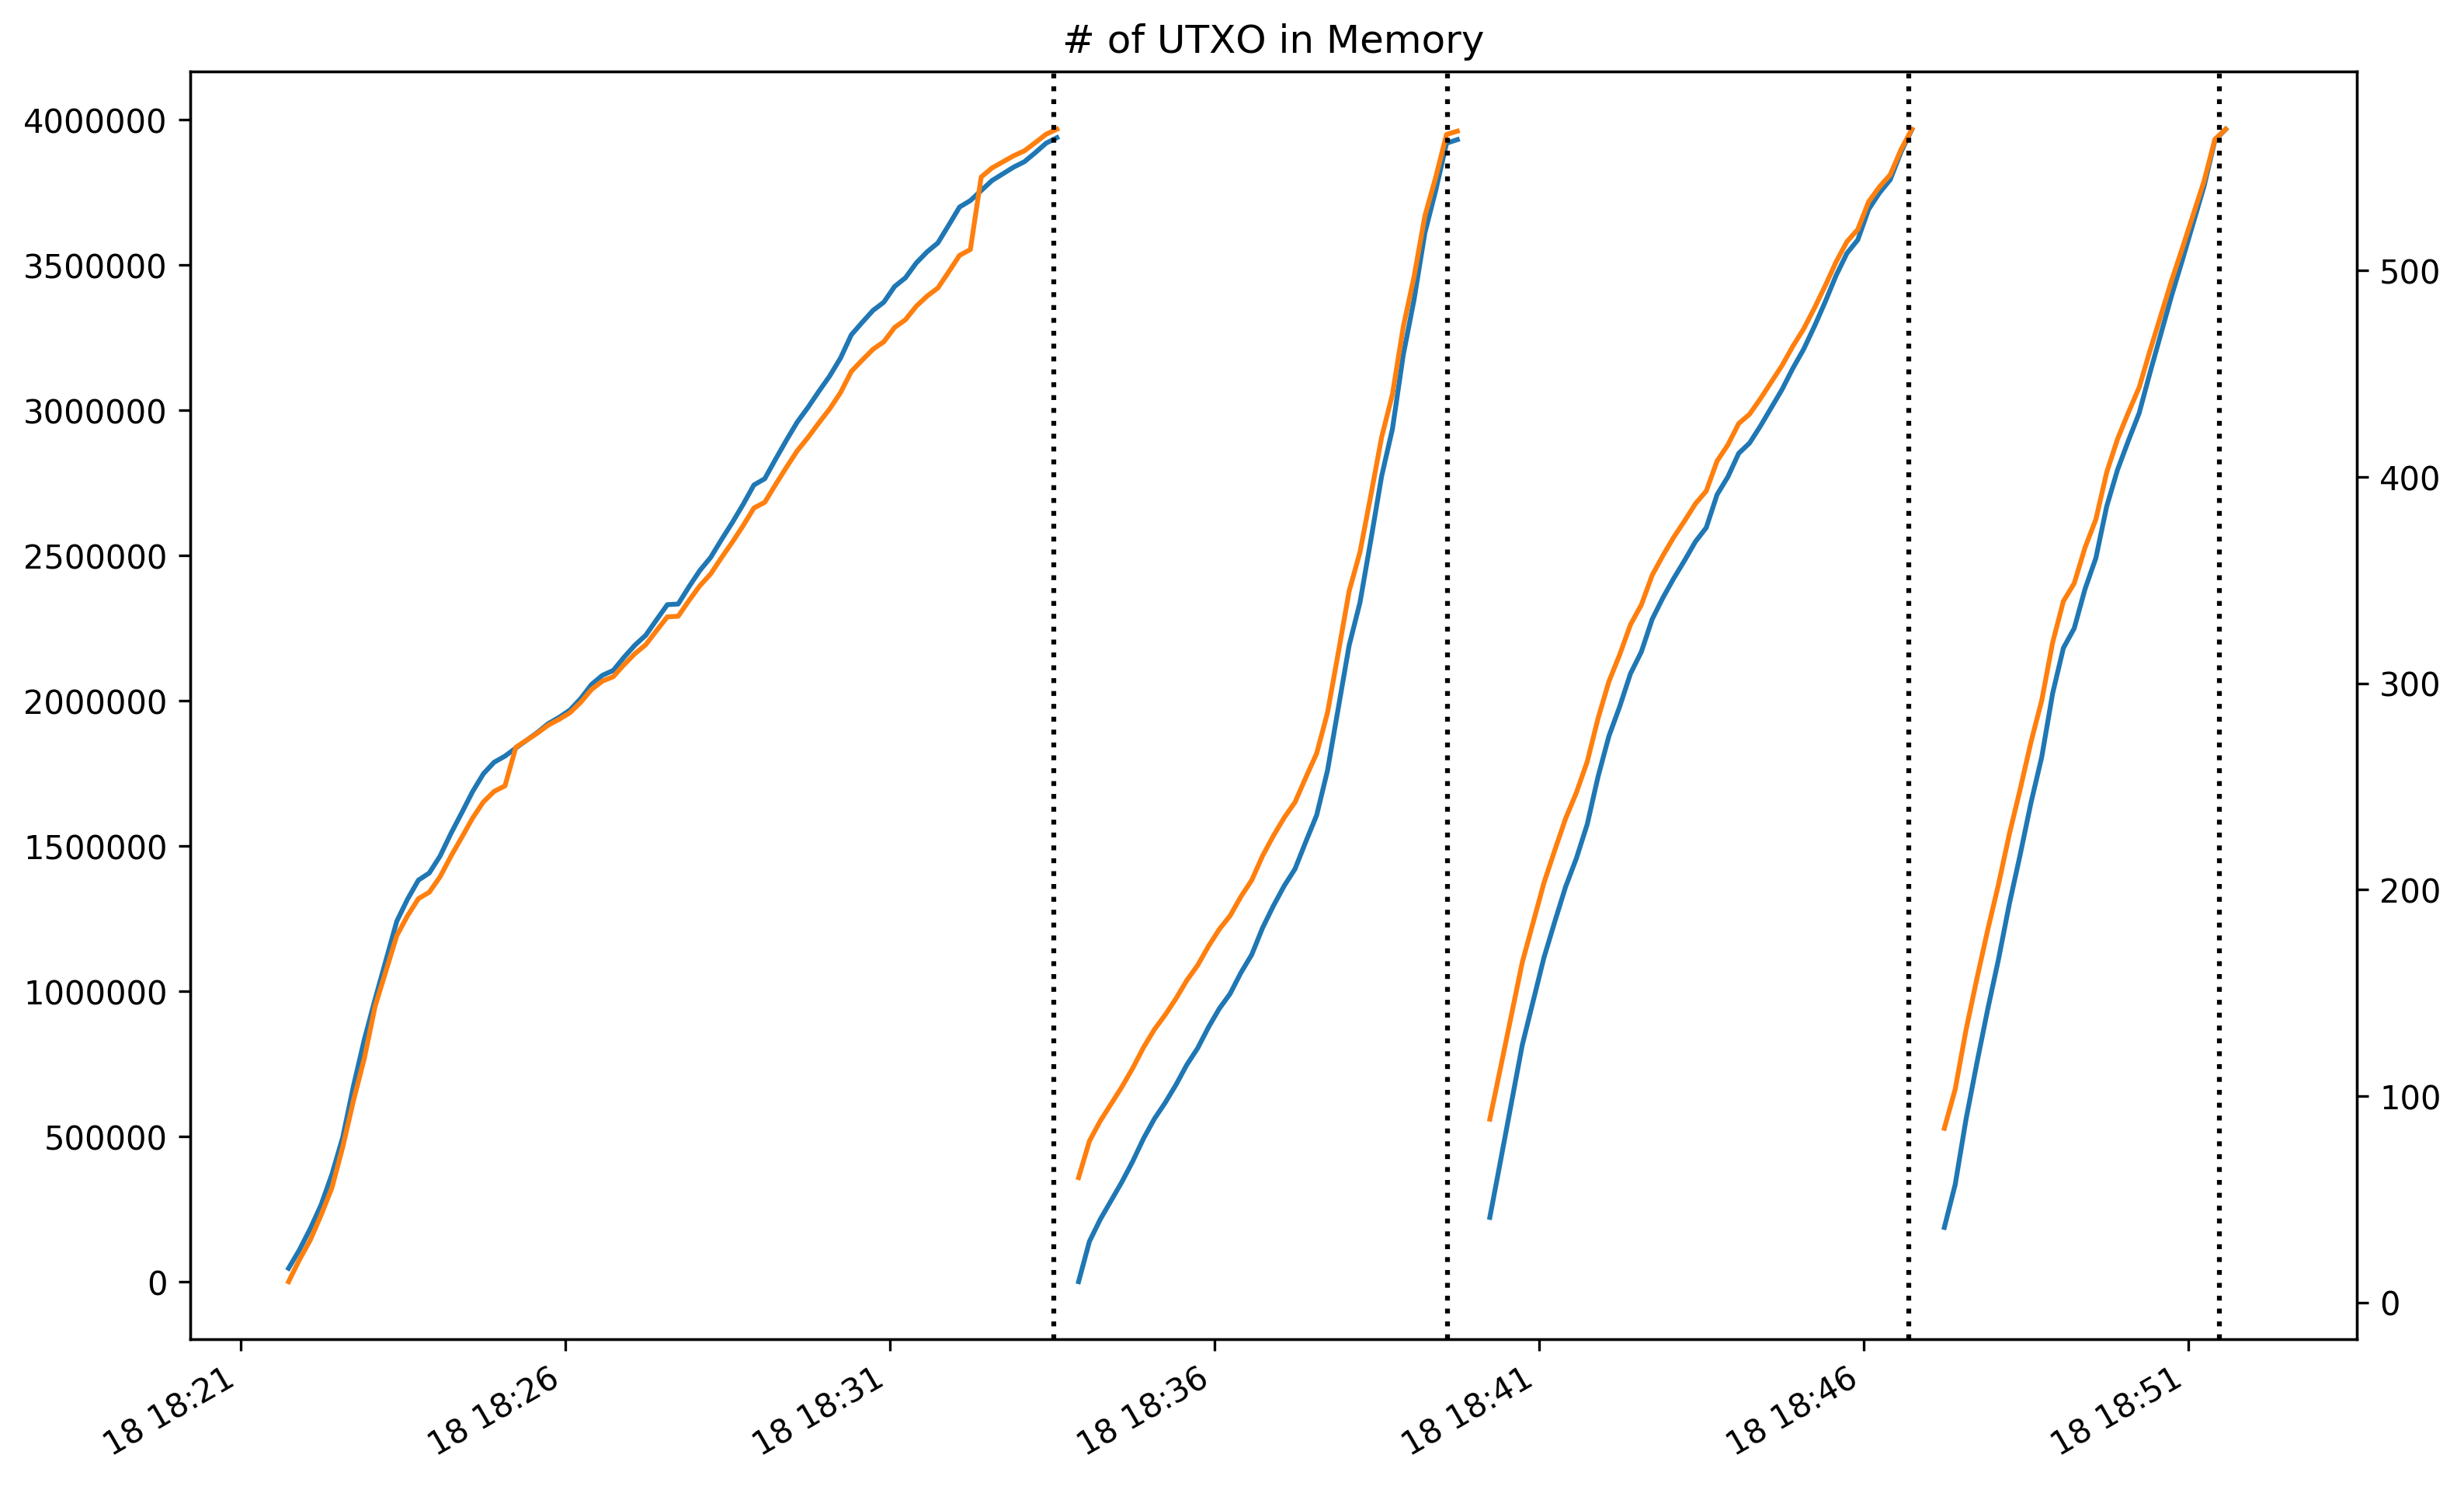

In [69]:
dualplot(updatetip['utxo:count'], updatetip['utxo:size']/1e6, title='# of UTXO in Memory')
#updatetip.head()

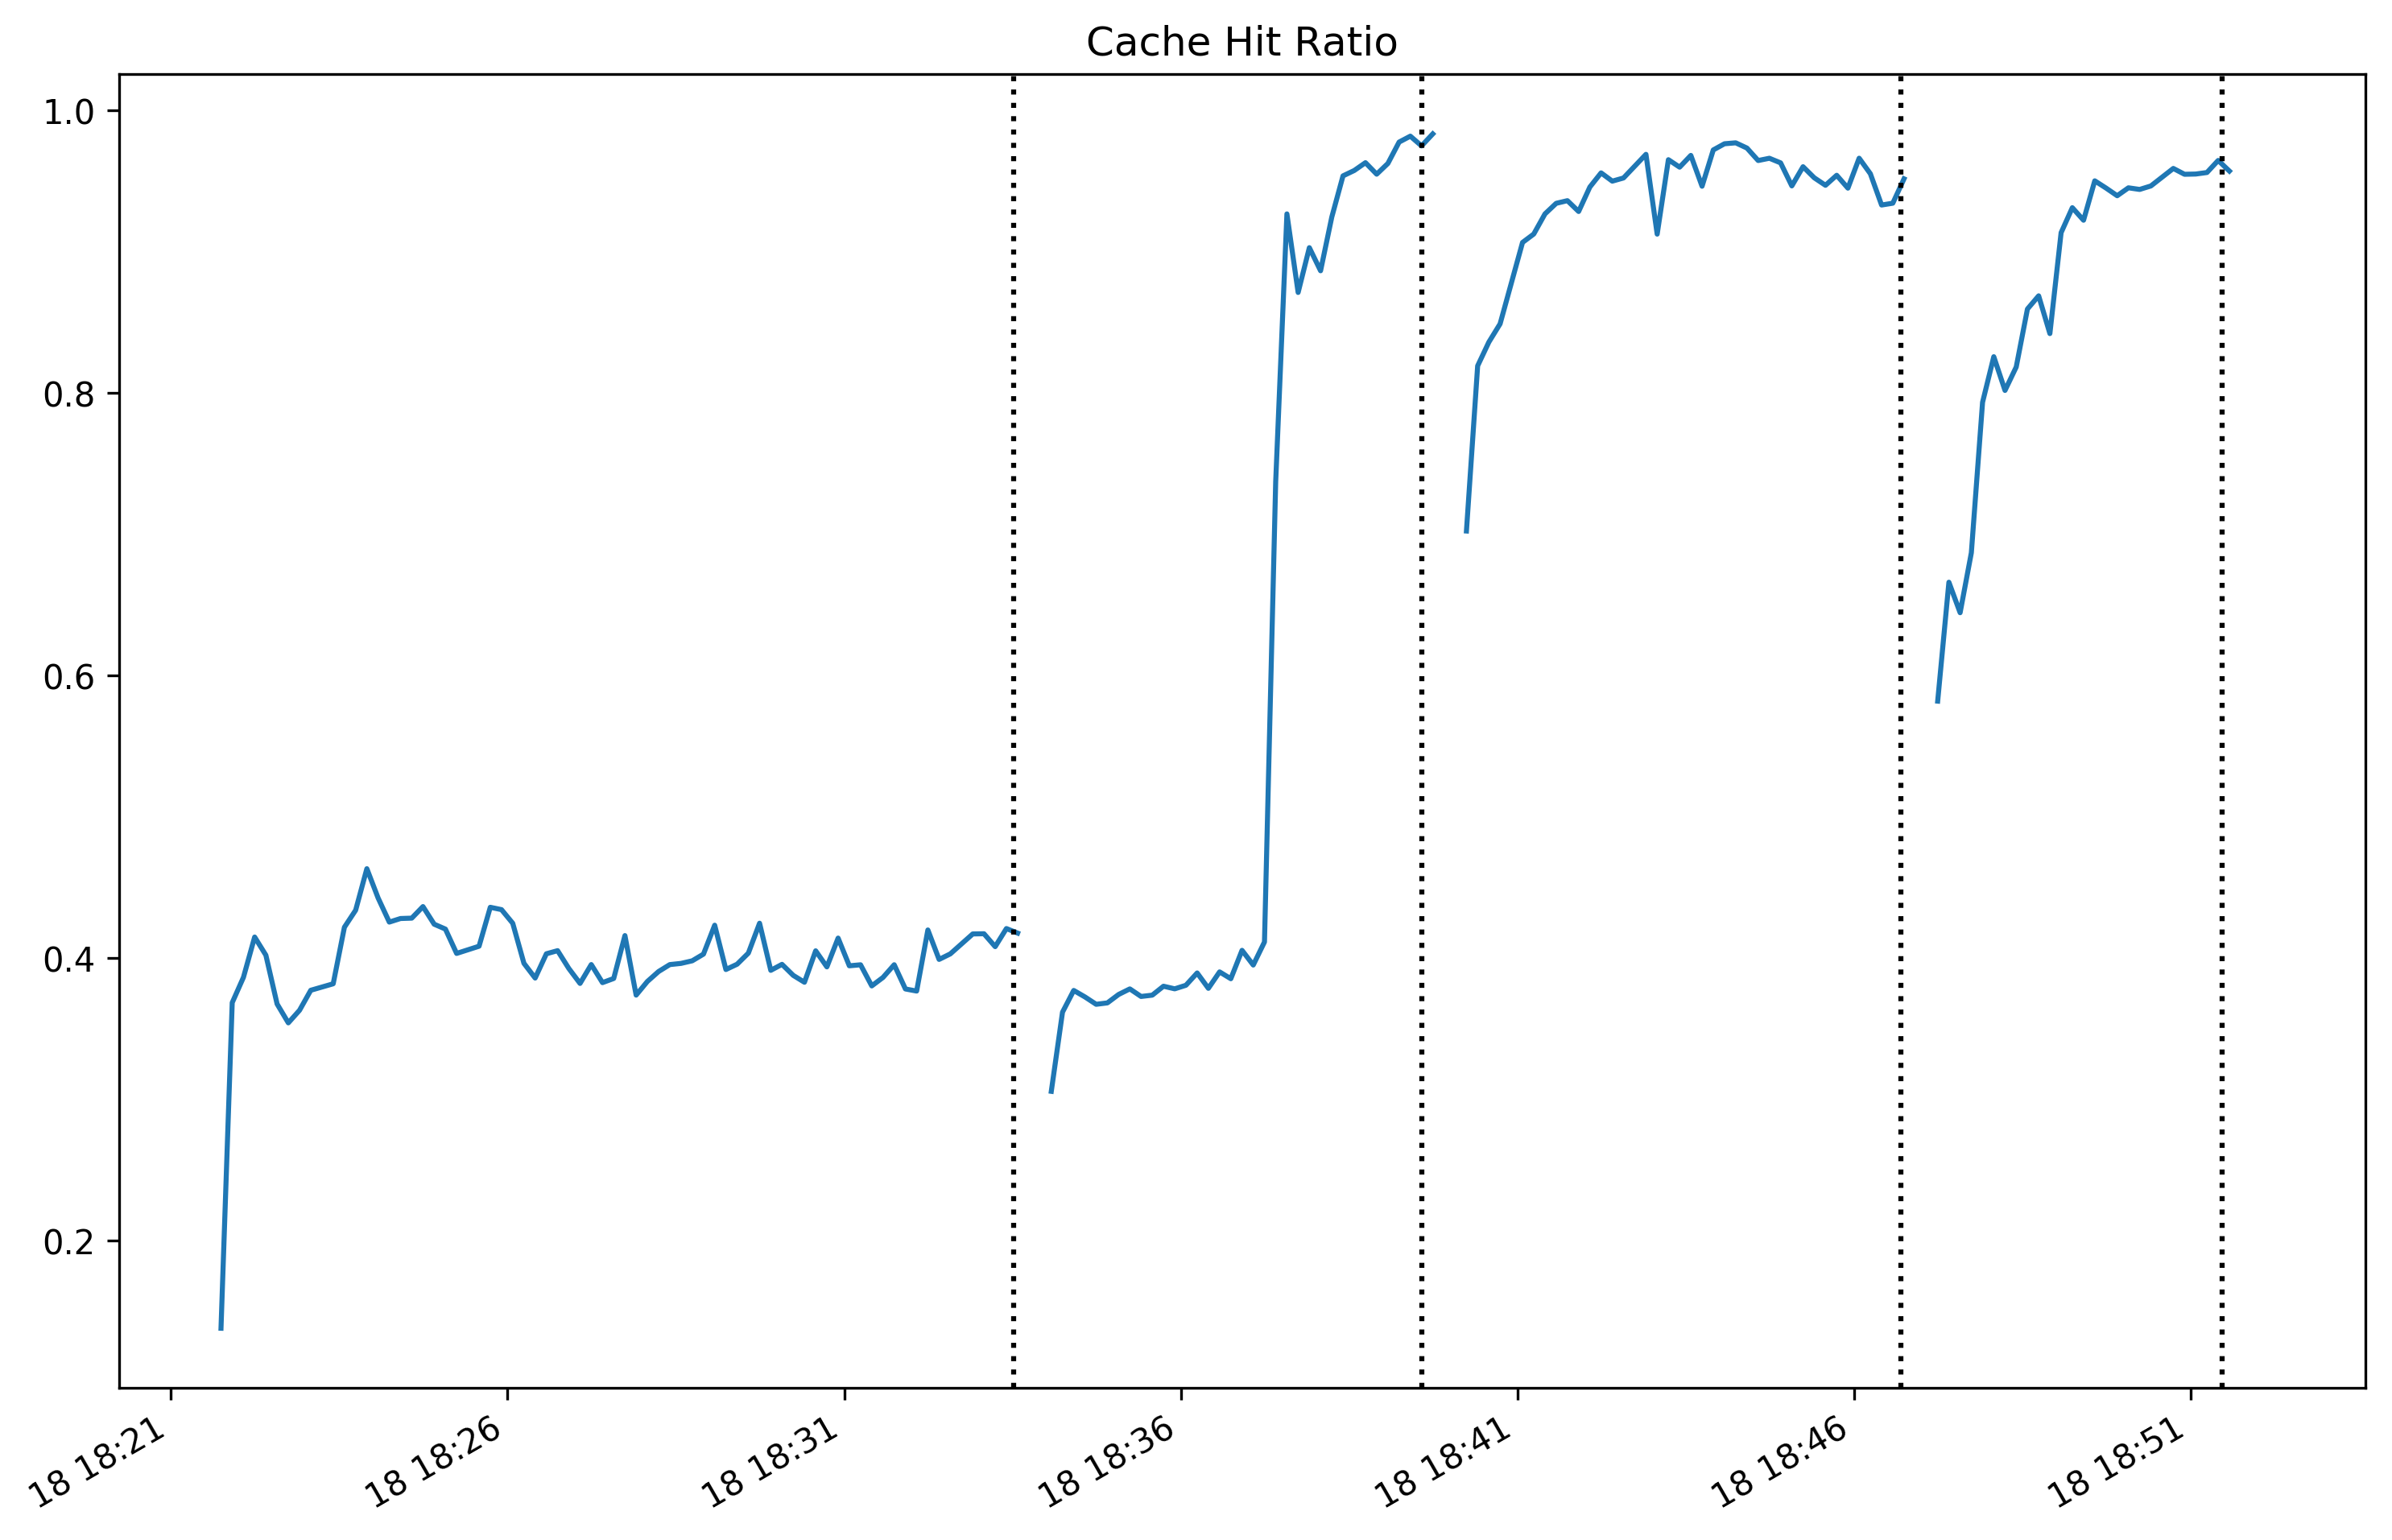

In [70]:
hits = cache['hits']
total = hits + cache['misses']
plot(hits / total, title='Cache Hit Ratio')

In [71]:
sum(hits/sum(total))

0.5932521247190711

## Disk / VFS Stats

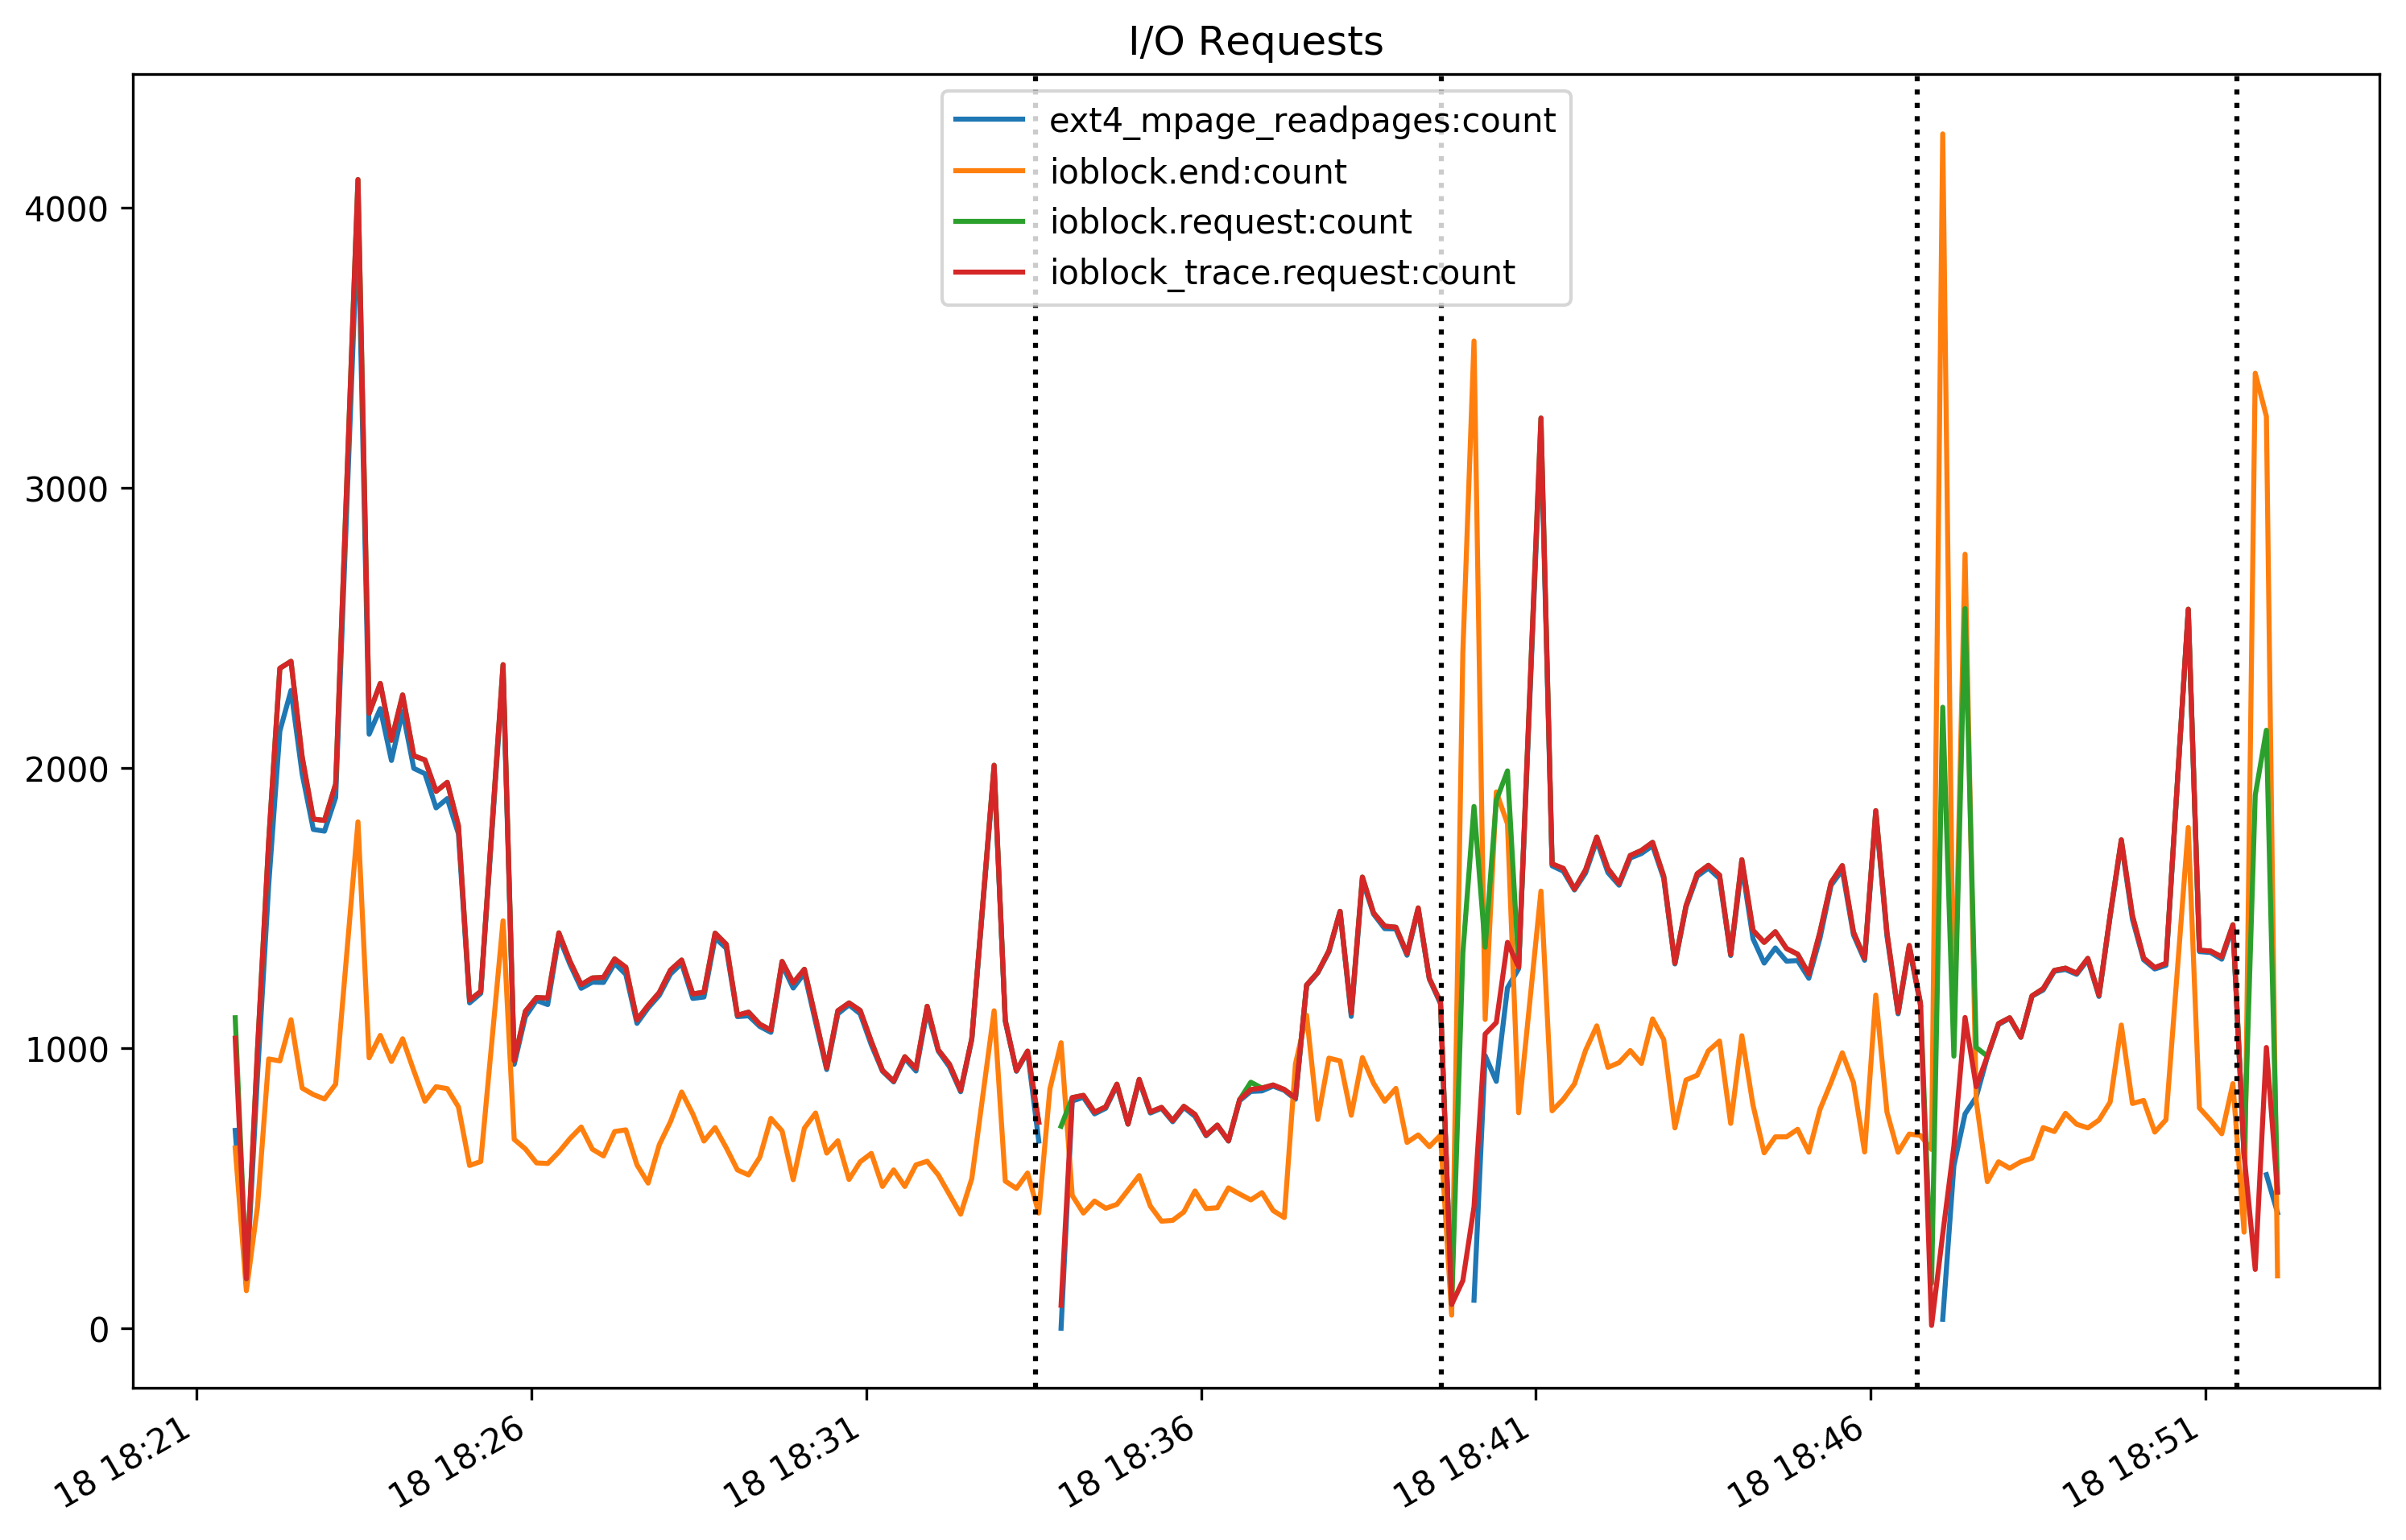

In [74]:
counts = [c for c in bio.columns if c.endswith(':count')]
plot(bio[counts], title='I/O Requests')

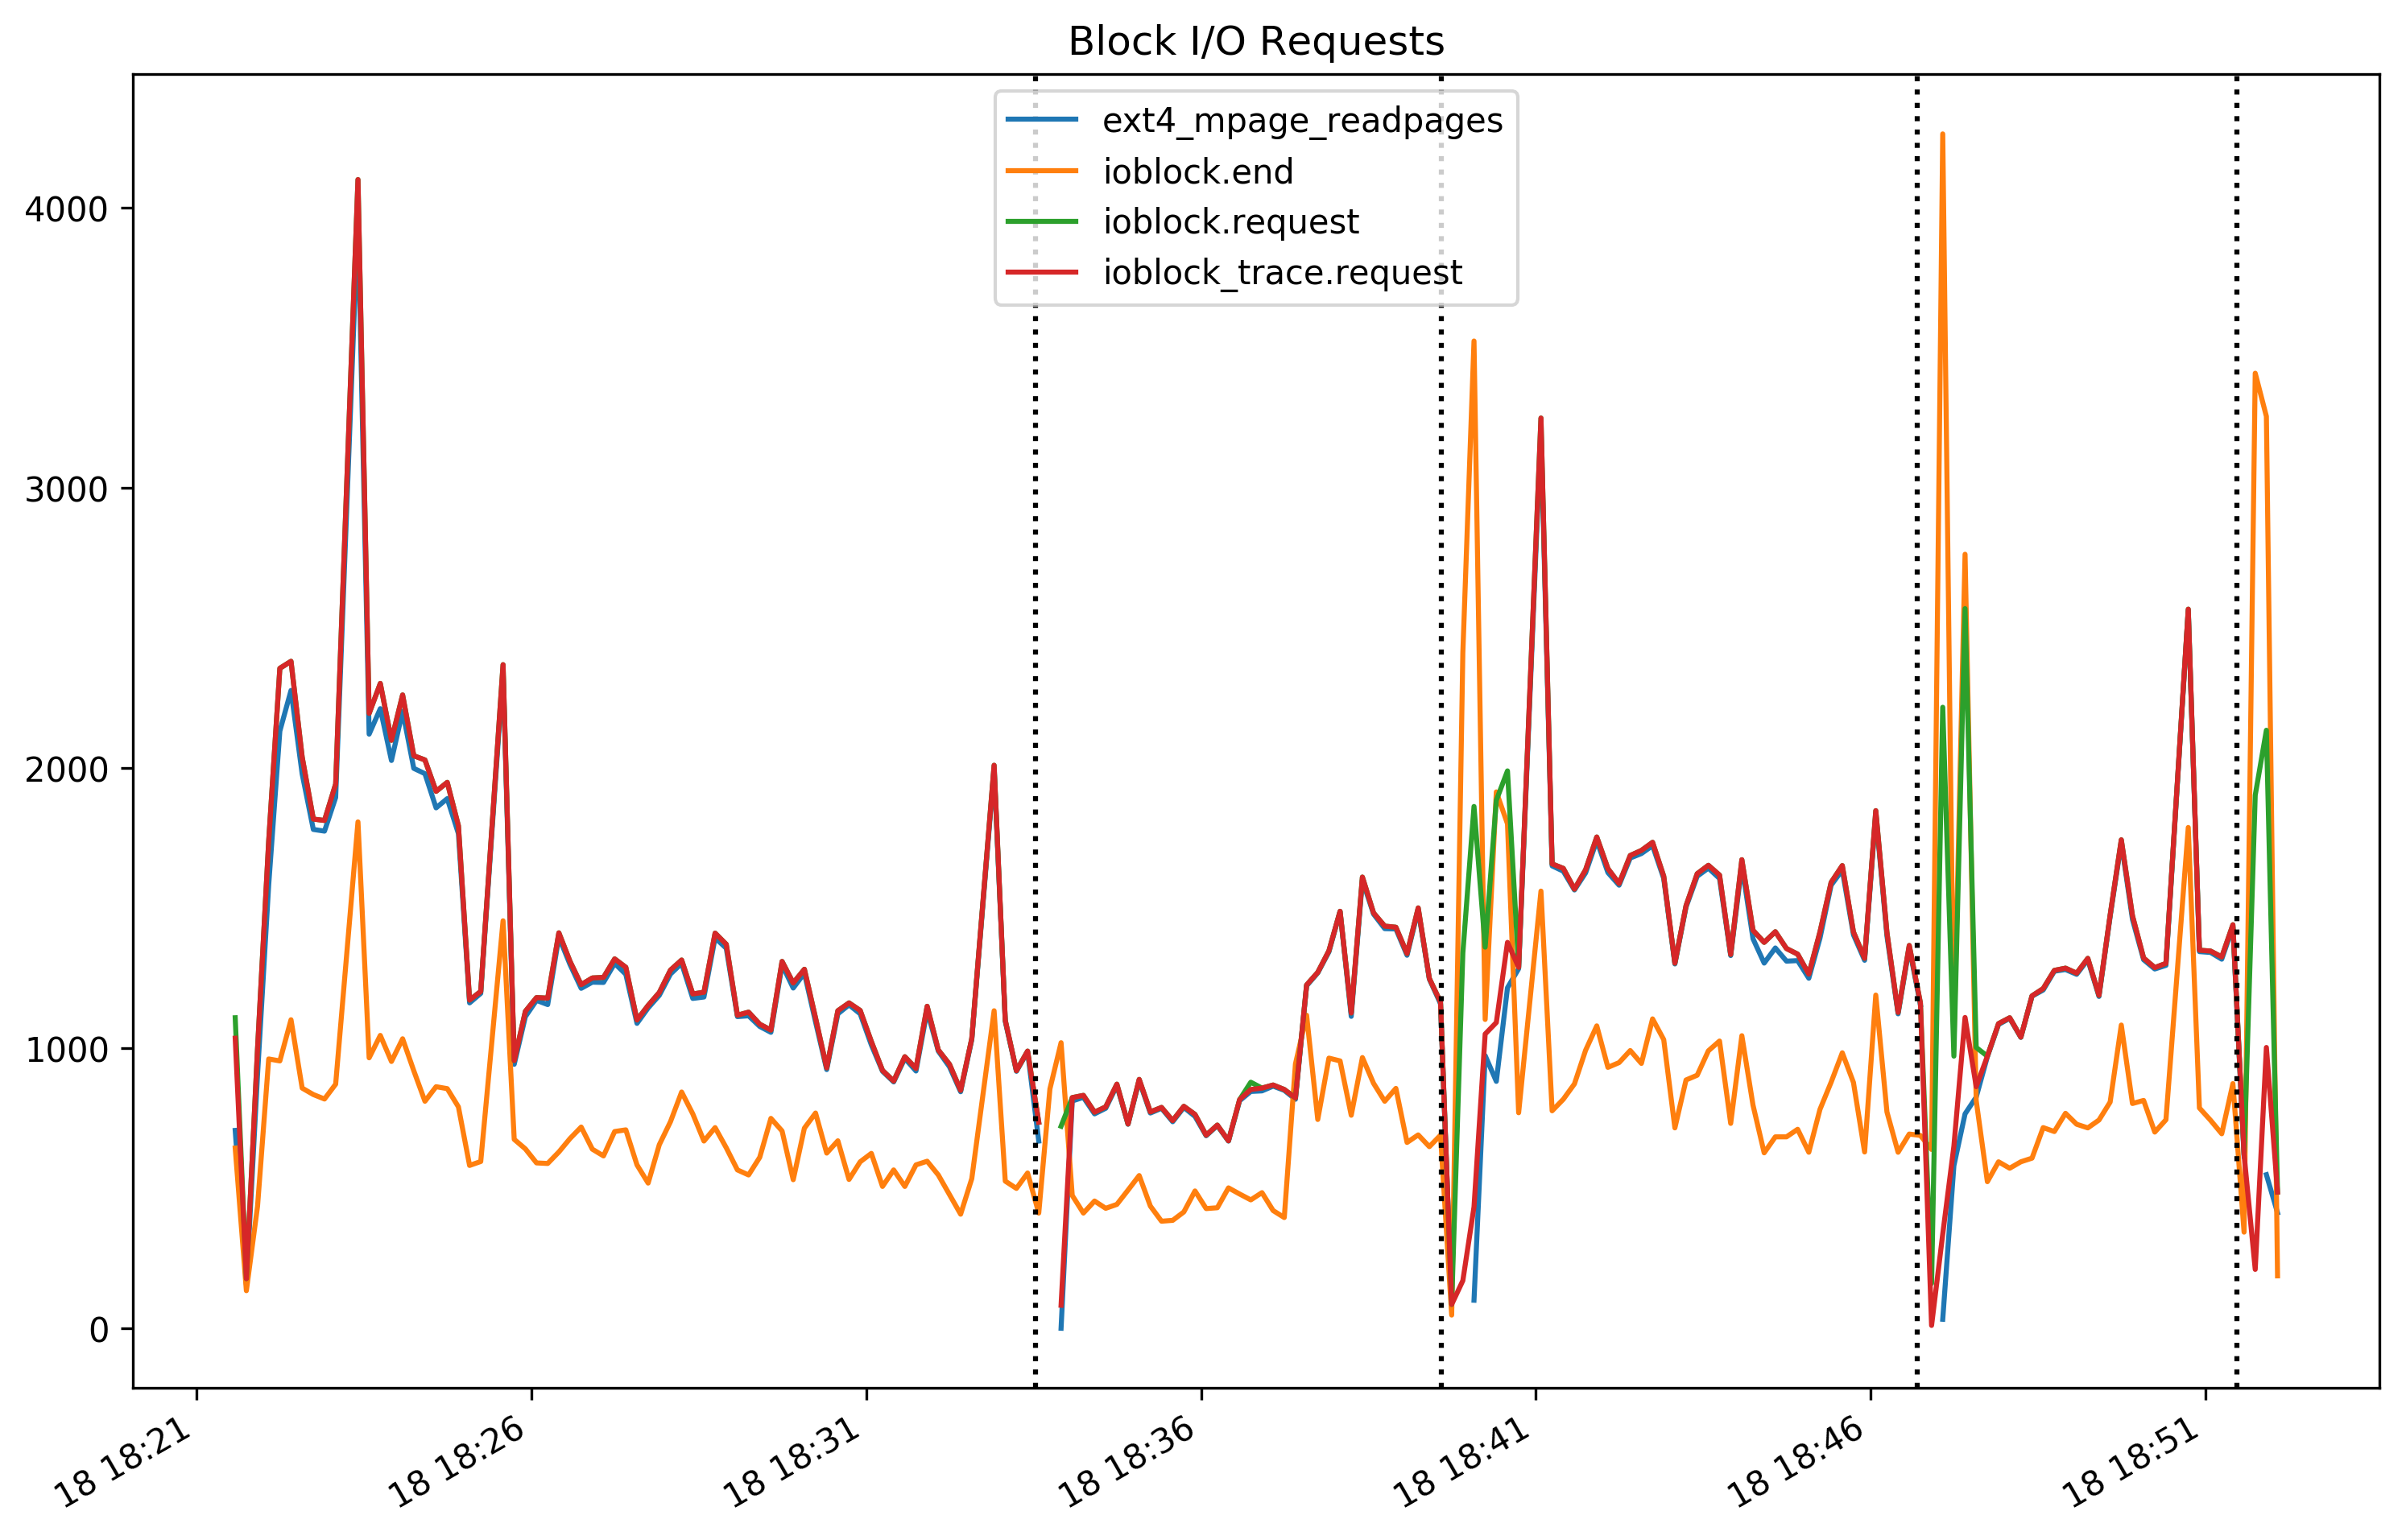

In [83]:
def strip_suffix(label: str) -> str:
    return label.split(':')[0]

def select(df: pd.DataFrame, suffix: str):
    frame = df[[c for c in df.columns if c.endswith(':' + suffix)]]
    return frame.rename(strip_suffix, axis='columns')    

plot(select(bio, 'count'), title='Block I/O Requests')

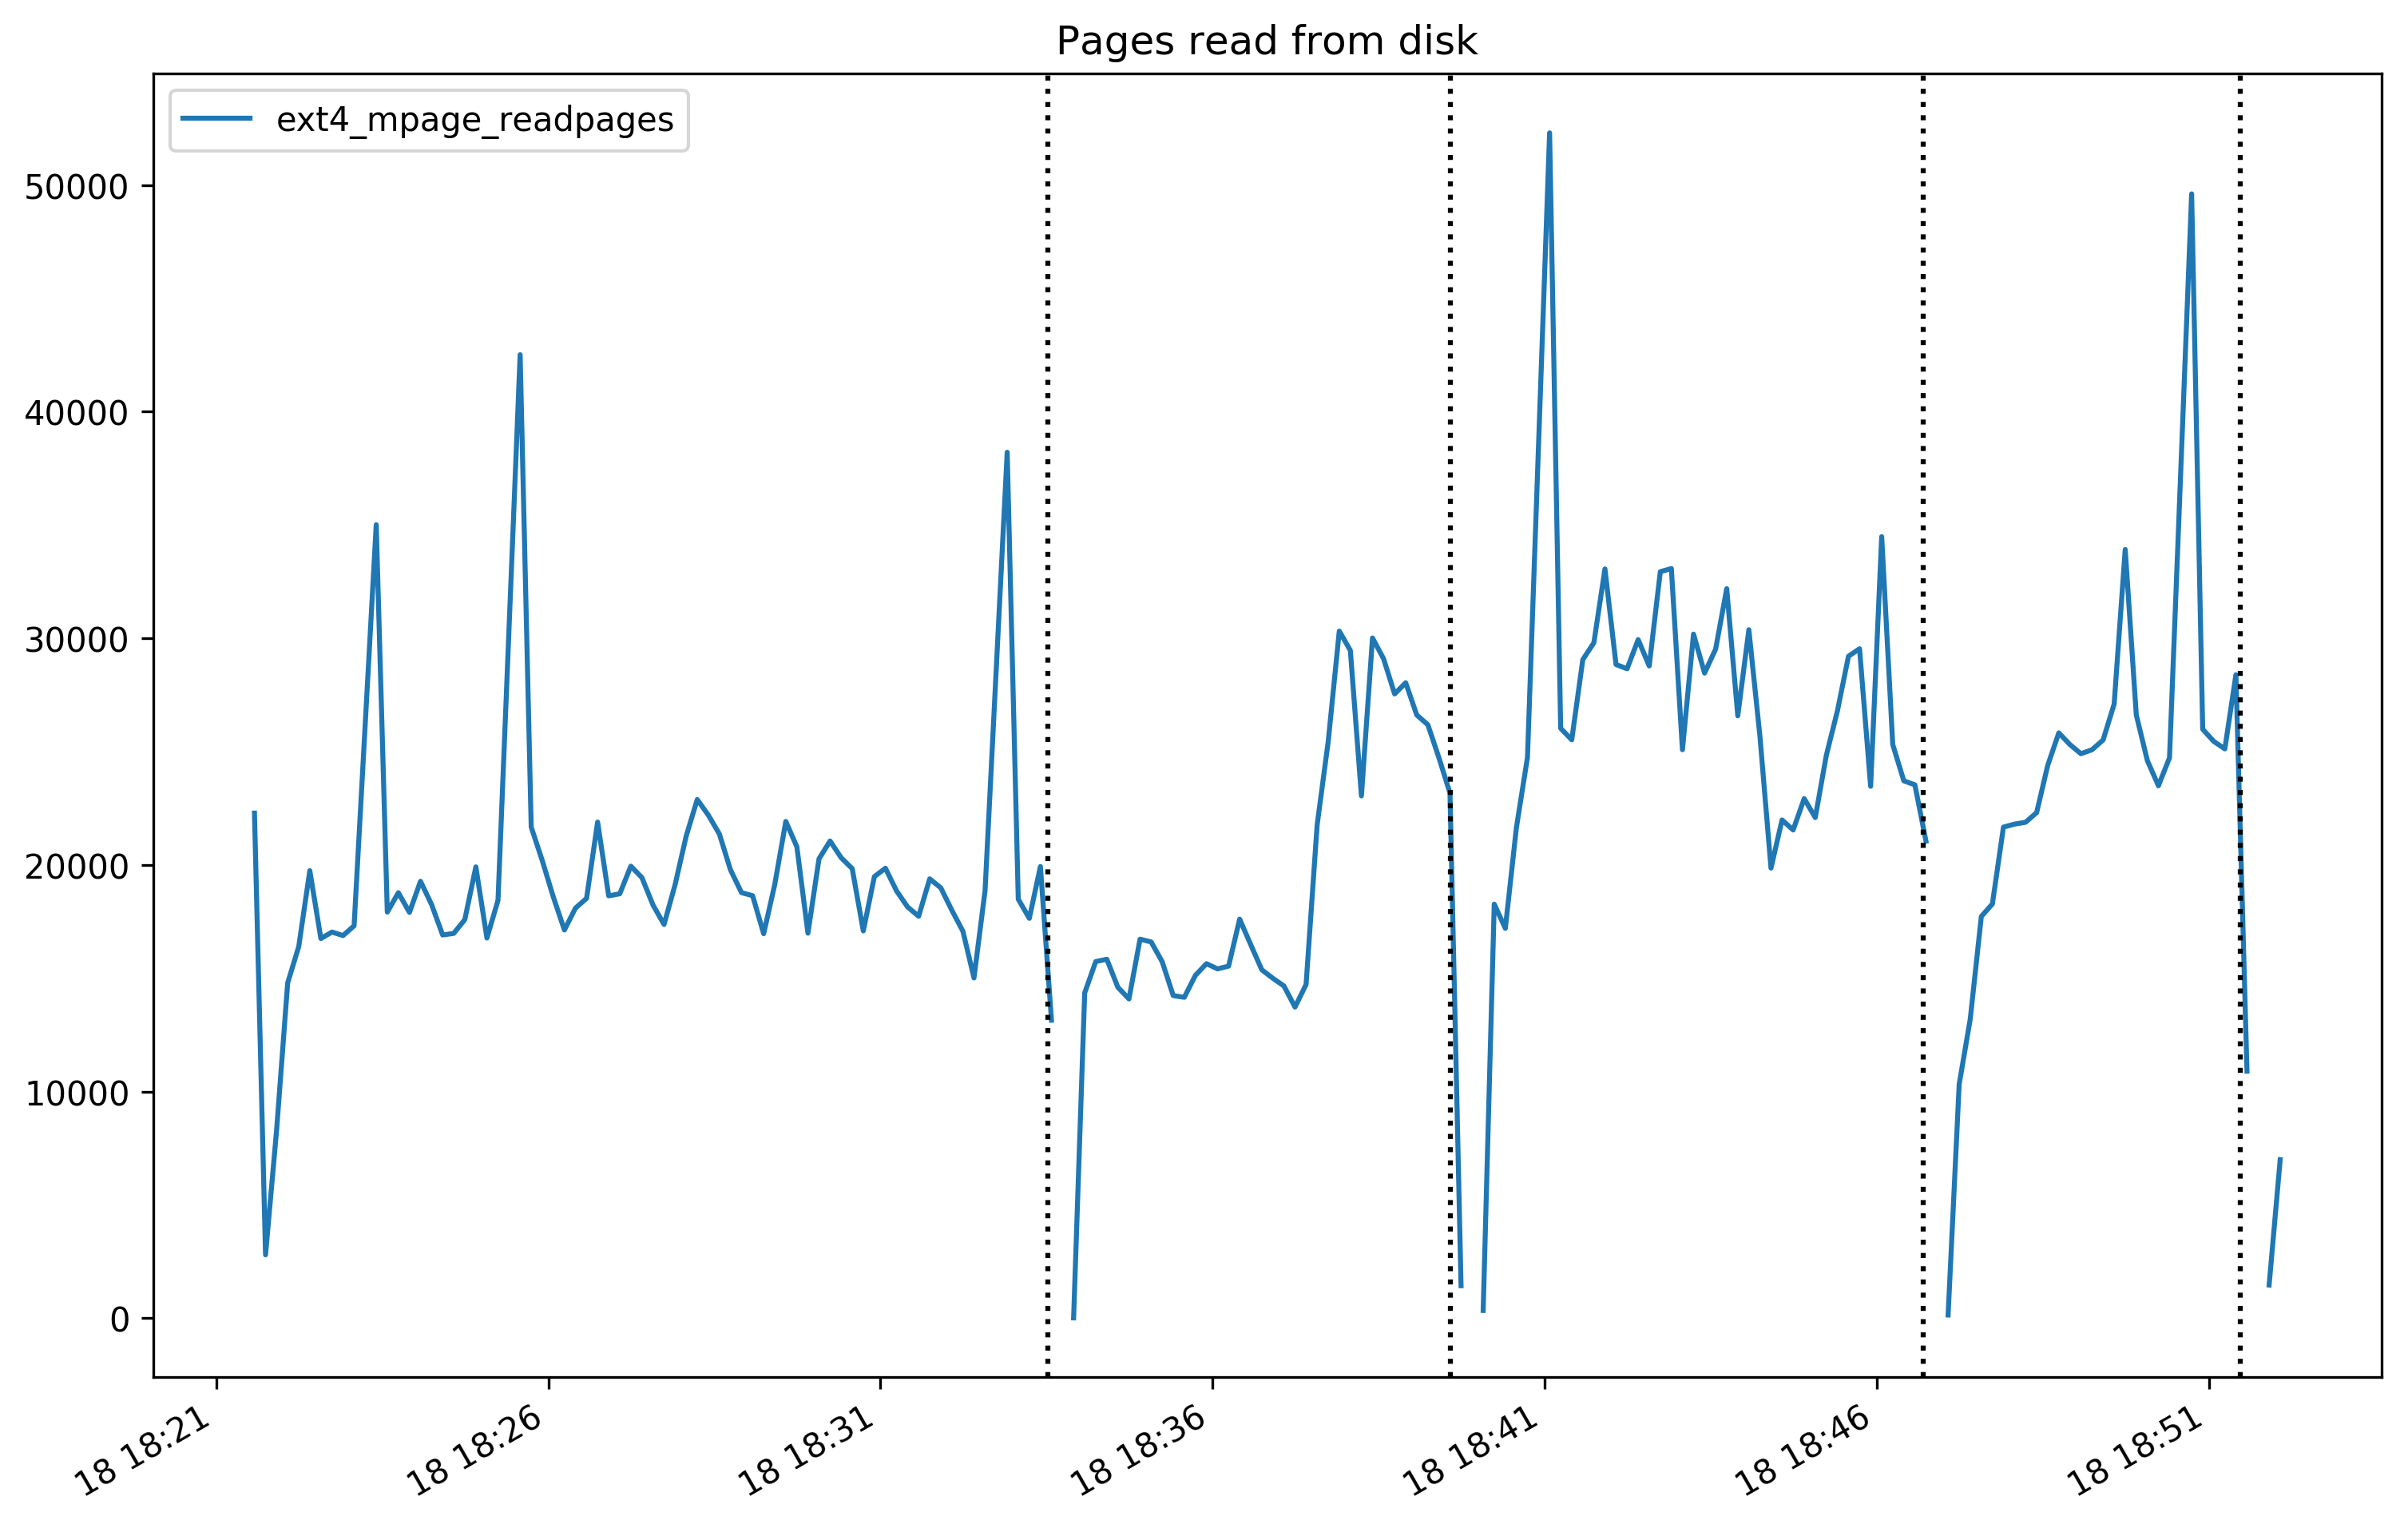

In [84]:
plot(select(bio, 'pages'), title='Pages read from disk')

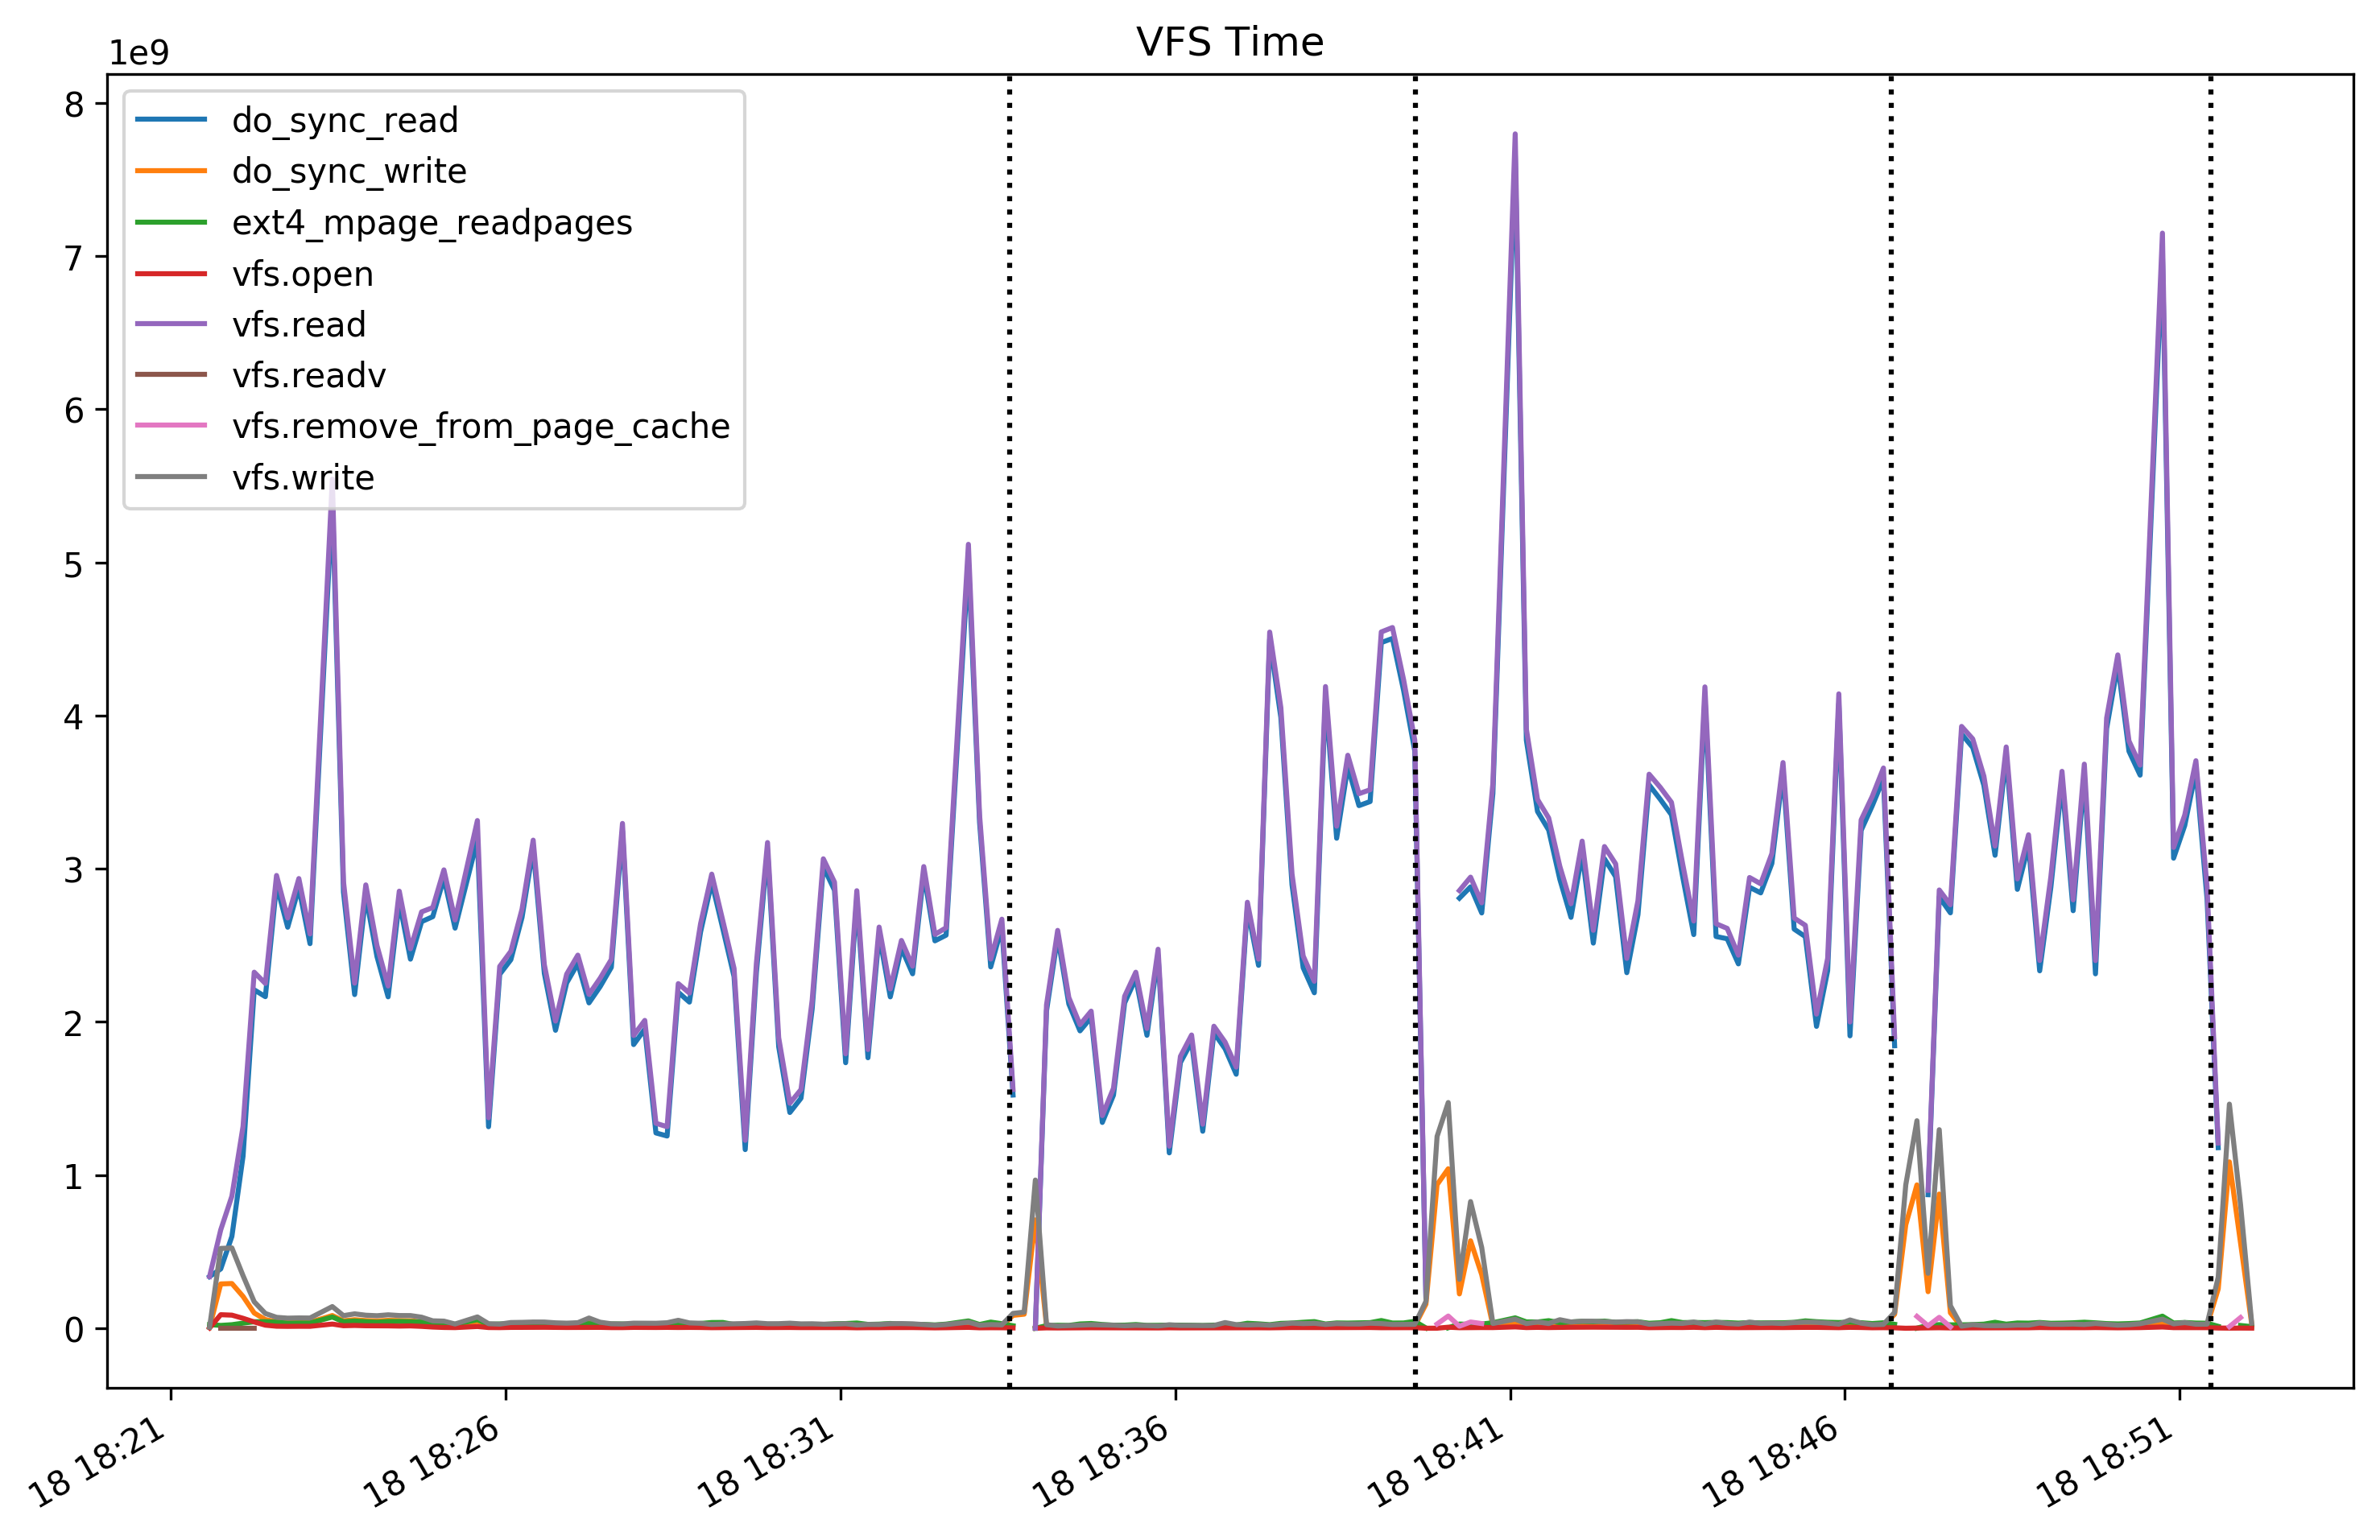

In [100]:
plot(select(vfs, 'time'), title="VFS Time")

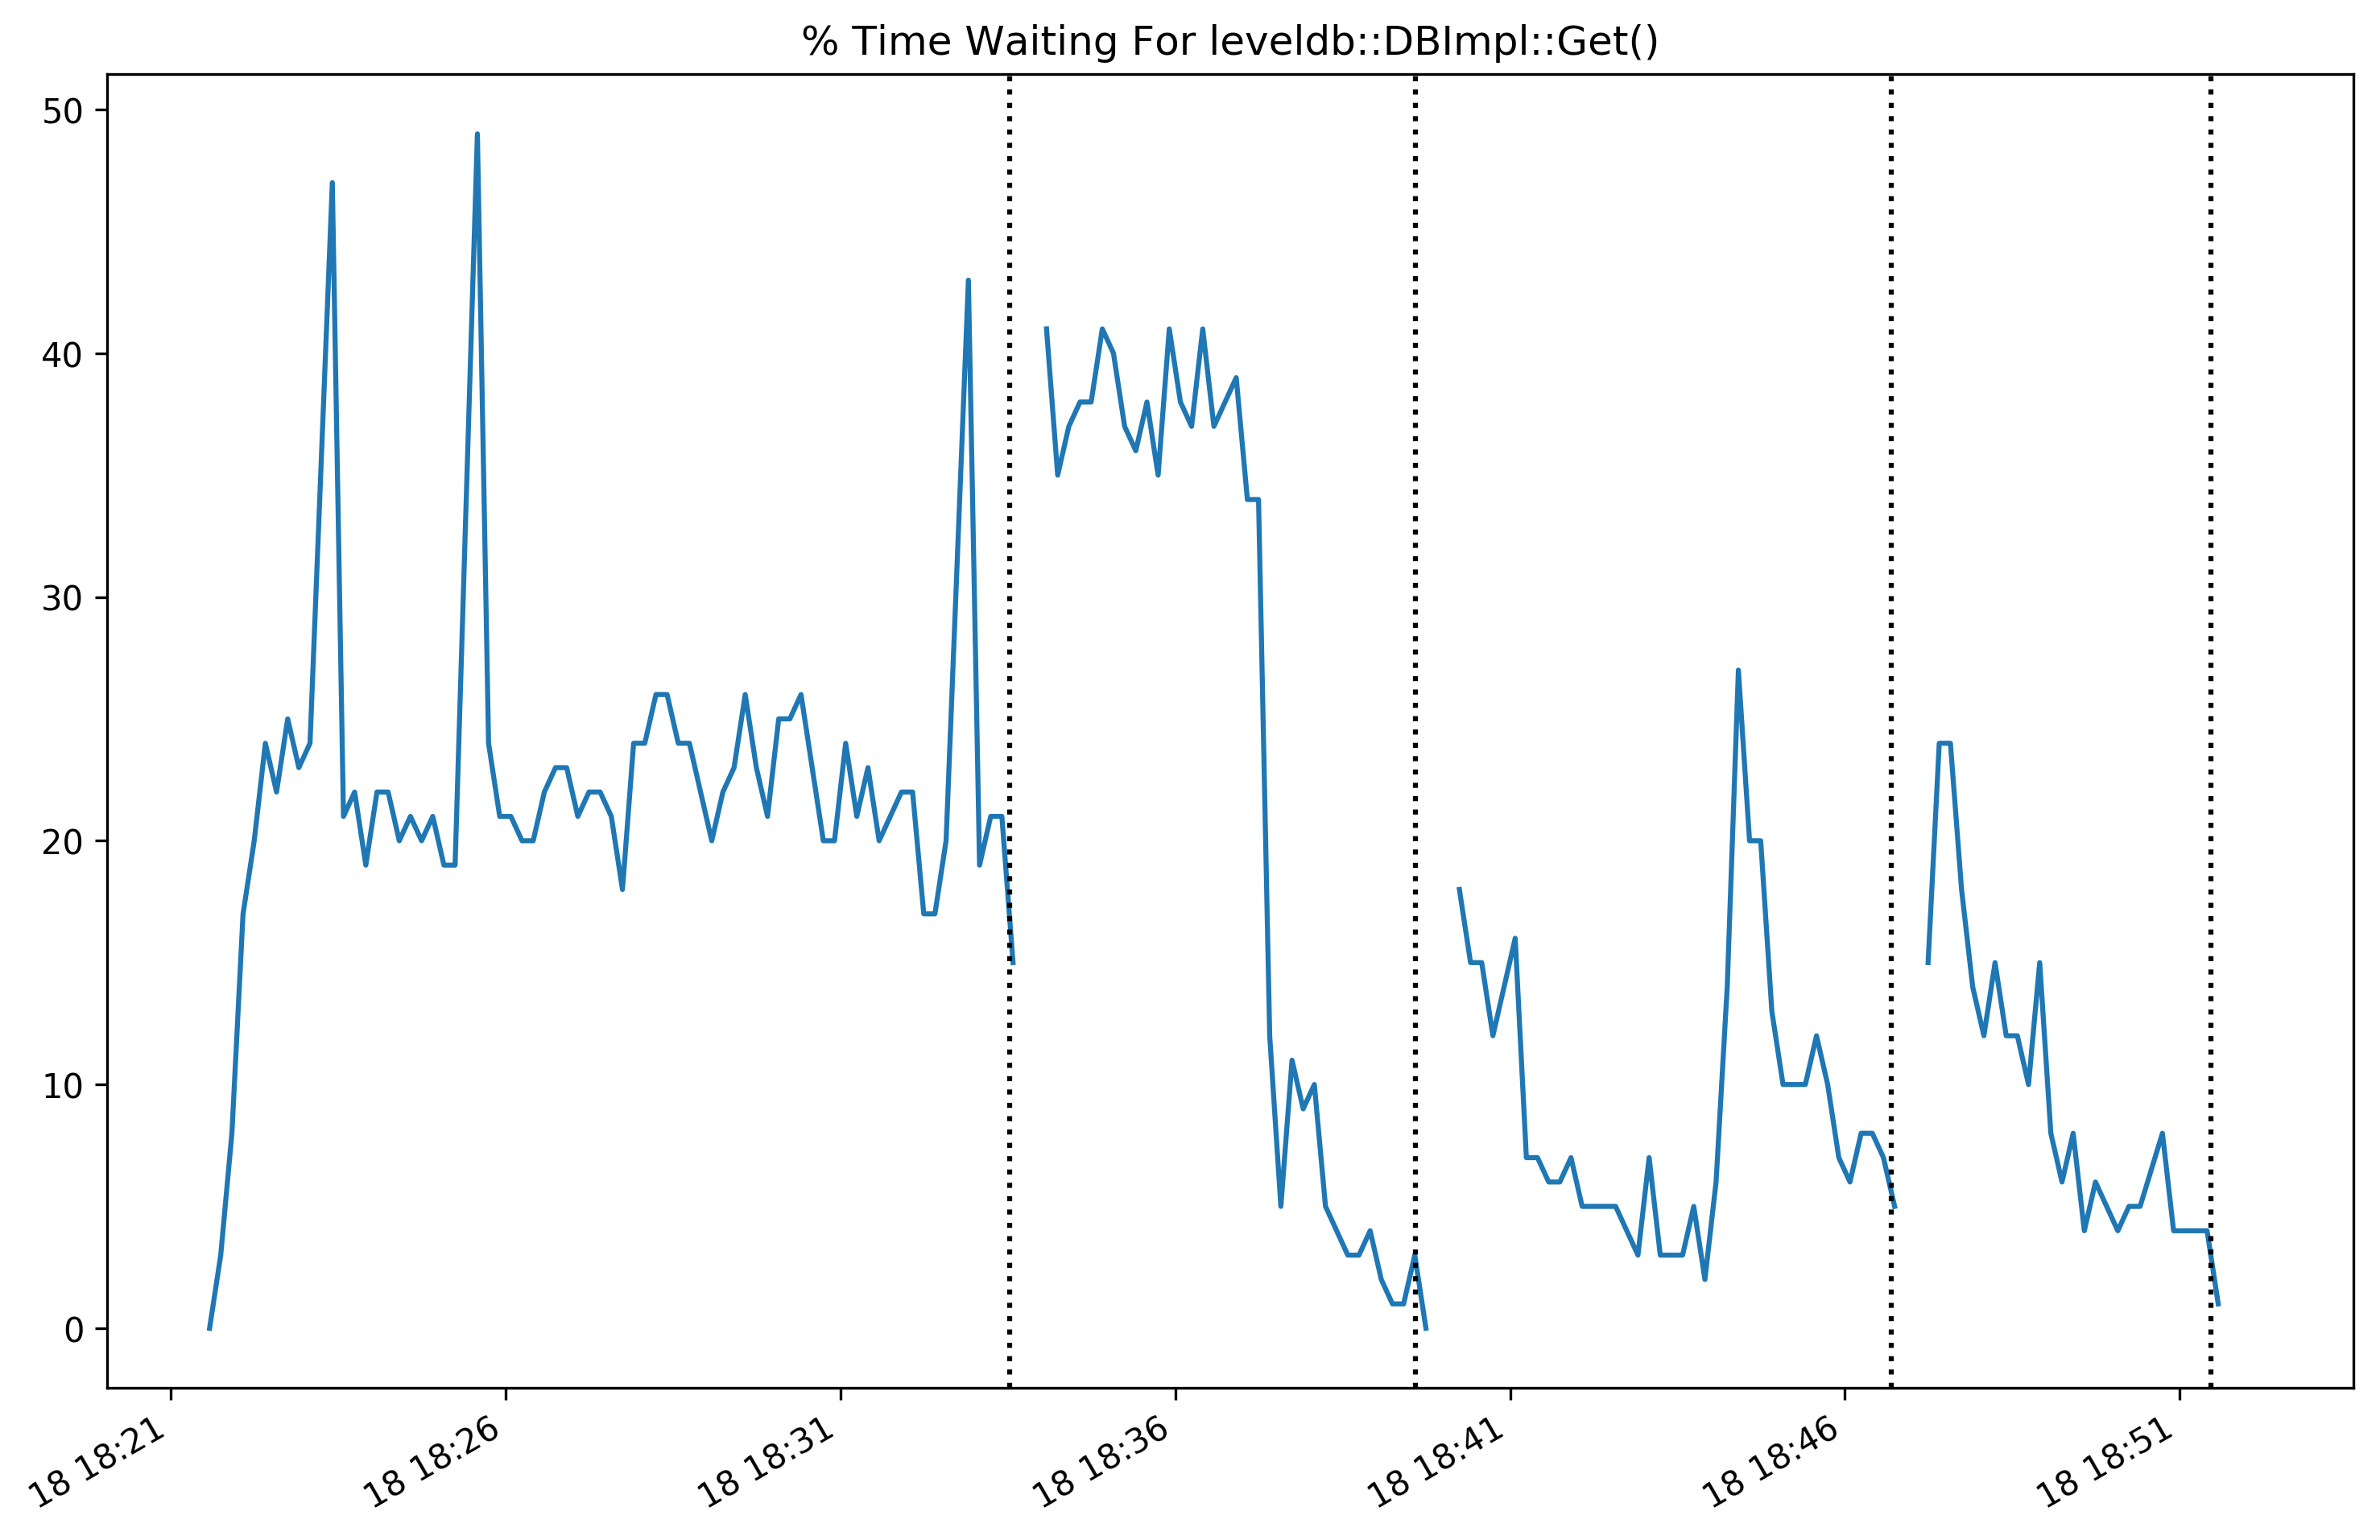

In [109]:
plot(leveldb['get:time']/1e8, title='% Time Waiting For leveldb::DBImpl::Get()')

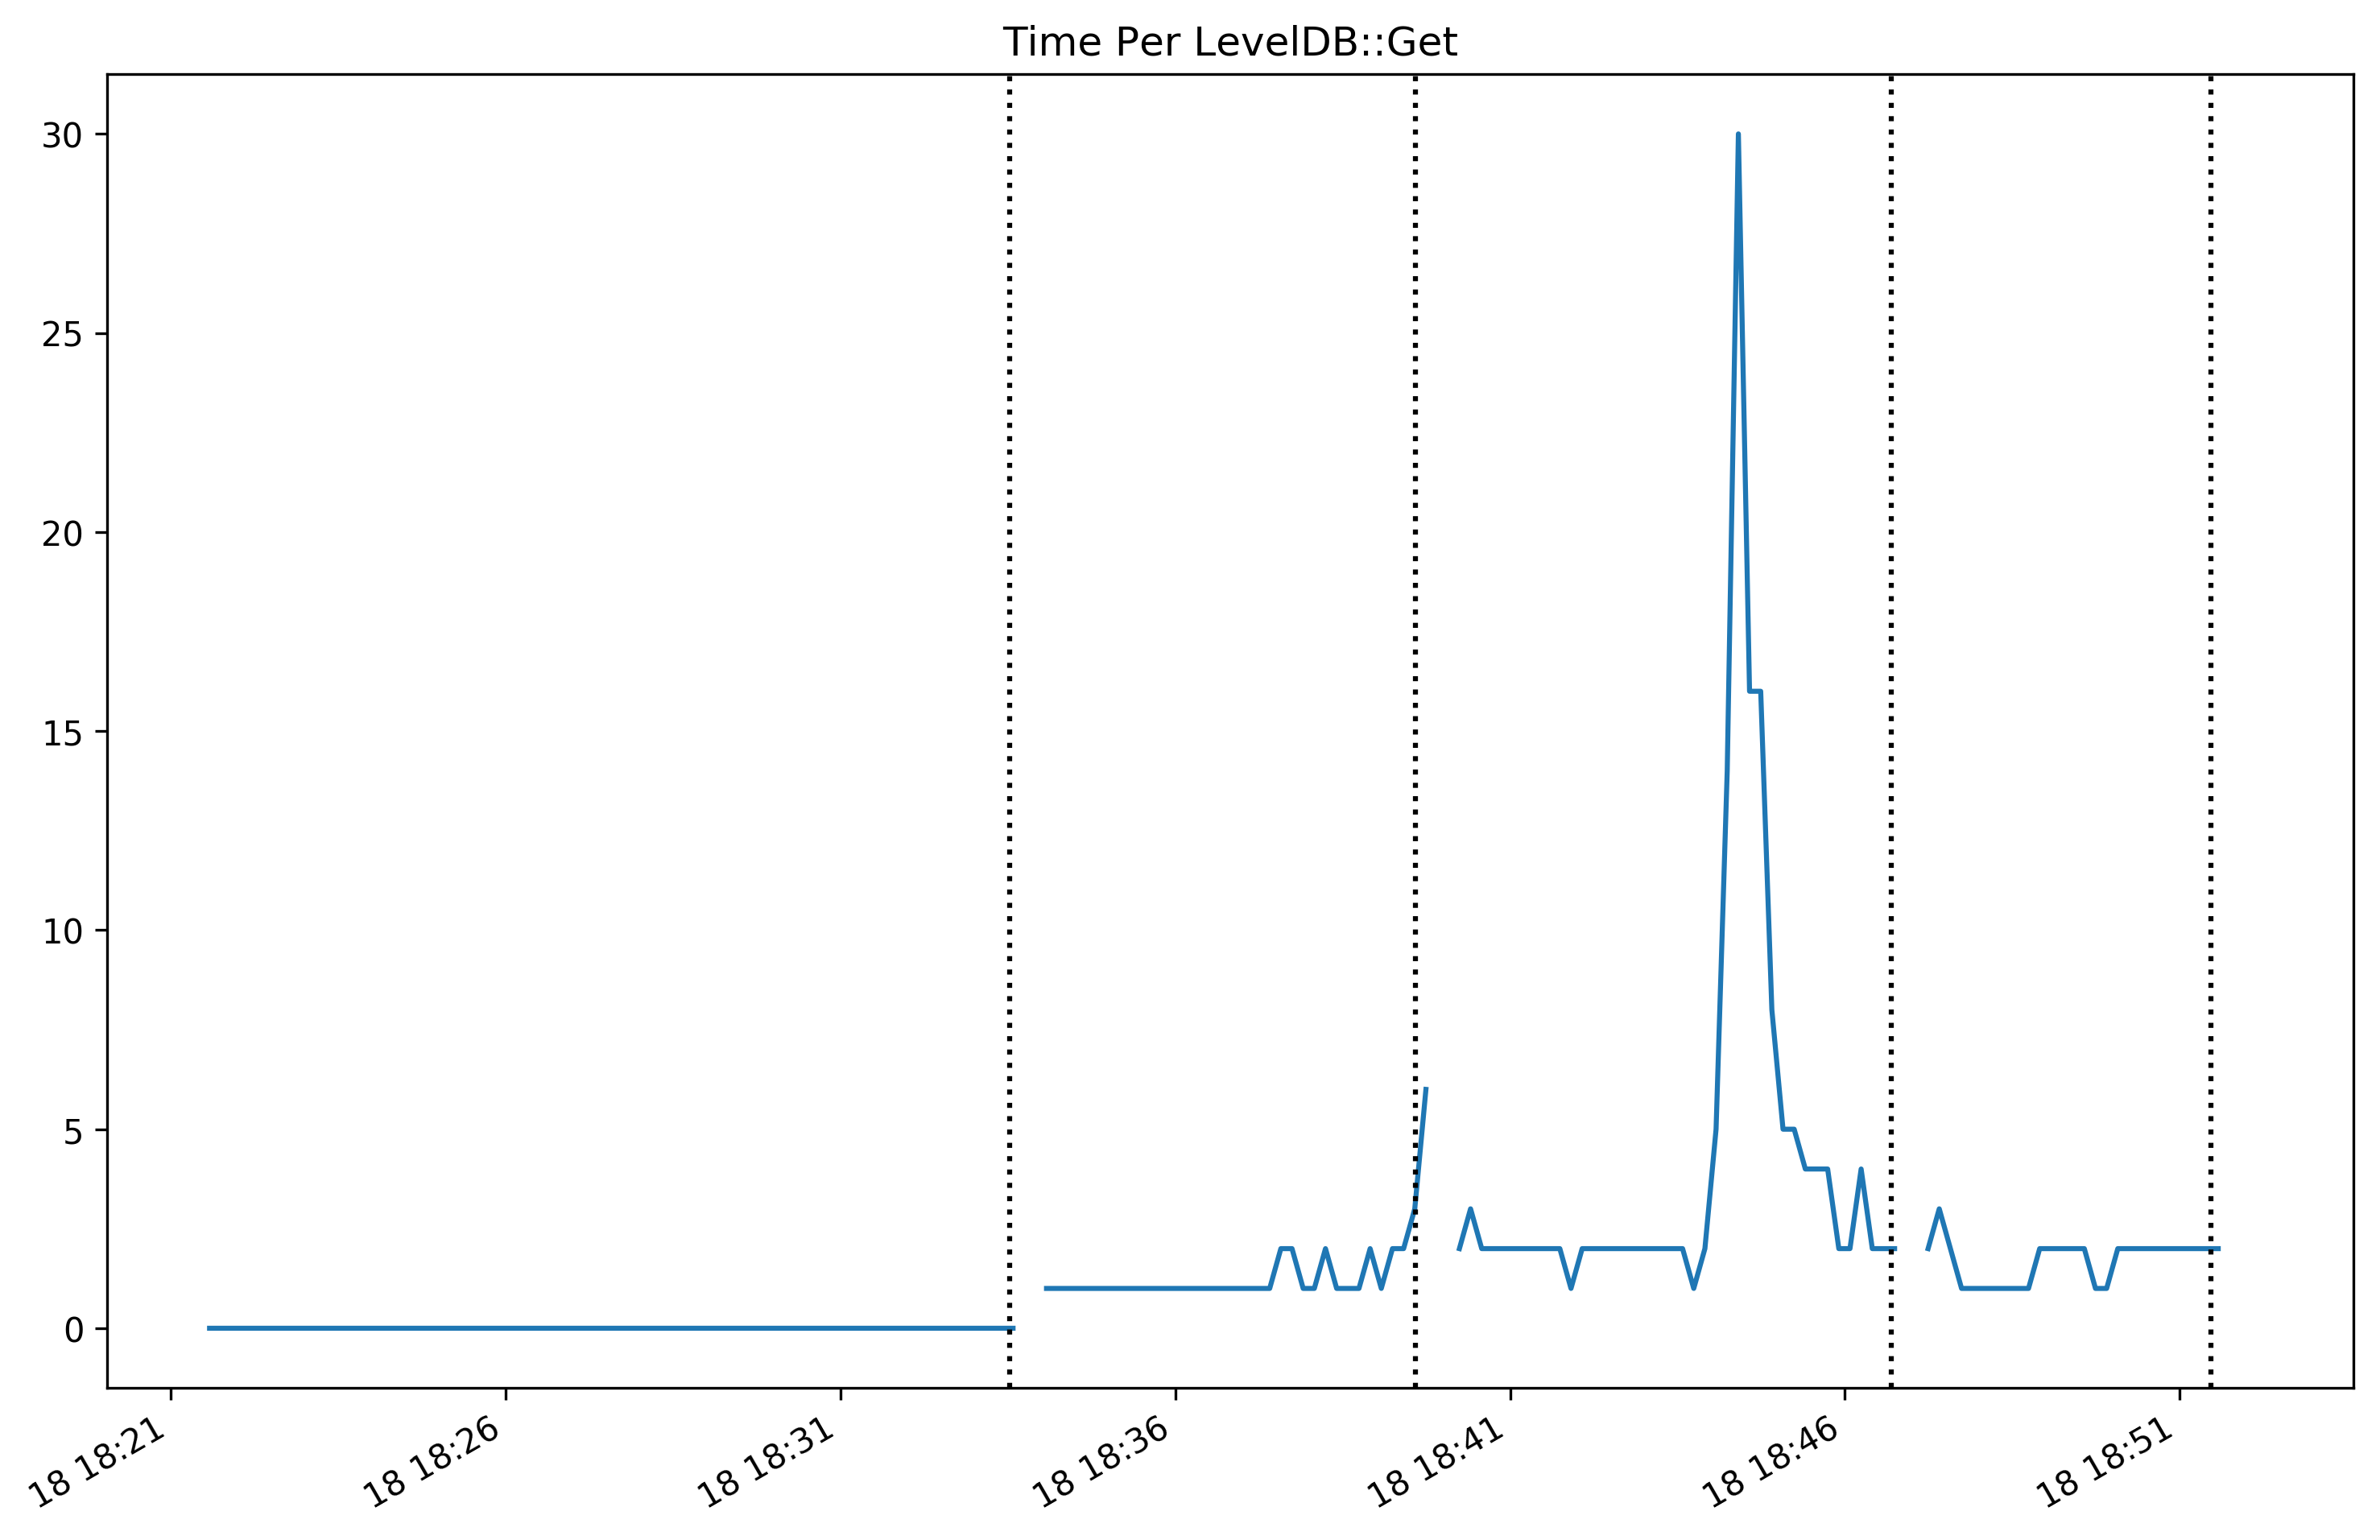

In [116]:
plot((leveldb['get:time']/1e4)/leveldb['get:count'], title='Time Per LevelDB::Get')